In [1]:
# Essential packages
import pandas as pd
import numpy as np

# Plot packages
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import spearmanr

In [2]:
# Pacotes para implementação de modelos de Machine Learning
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Models packages
import lightgbm as lgb
import xgboost as xgb
from sklearn.cluster import KMeans

# Model optimization packages
import optuna
#optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# **Introdução**

Uma empresa de táxi da cidade de Nova York deseja desenvolver um aplicativo para prever a duração das viagens que serão feitas. Para isso, foi disponibilizado um conjunto de dados de viagem da NYC Taxi and Limousine Commission, que inclui tempo de coleta, geocoordenadas, número de passageiros e várias outras variáveis.

Com base nisso, este projeto desenvolverá um algoritmo de regressão de aprendizado de máquina capaz de prever a duração de uma viagem com base nas variáveis fornecidas pelo usuário do aplicativo (passageiro) e pelo motorista.

Neste notebook serão realizadas as seguintes etapas:
- Introdução: Visa esclarecer o objetivo do projeto e as etapas a serem seguidas.

- Limpeza e pré-processamento dos dados: Será feita uma pré-visualização dos dados, a fim de identificar e tratar dados inconsistentes e ausentes, além de criar recursos extras com base nos recursos iniciais.

- Análise Exploratória de Dados (EDA): Serão realizadas visualizações para encontrar insights relevantes para o desenvolvimento do algoritmo.

- Correlação: A correlação entre os dados será analisada a fim de evitar possíveis problemas de multicolinearidade.

- Implementação do modelo: É a etapa onde será criado e avaliado o modelo de aprendizado de máquina, onde serão ajustados os hiperparâmetros do modelo para melhorar o resultado do modelo, e será realizada a análise de importância de features do modelo final.

- Conclusão: Etapa onde serão feitos comentários a respeito do projeto realizado e também alguns levantamentos de melhorias futuras para o projeto.

In [3]:
df_train = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')

# **Limpeza e pré-processamento dos dados**

In [4]:
df_train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Descrição do conjunto de dados:
* id: Um identificador único para cada viagem - (Categórico);
* vendor_id: Um código que indica o provedor associado ao registro da viagem - (Categórico);
* pickup_datetime: Data e hora em que o medidor foi acionado - (Datetime numérico);
* dropoff_datetime: Data e hora em que o medidor foi desengatado - (Datetime Numérico);
* passage_count: O número de passageiros no veículo (valor digitado pelo motorista) - (Numérico);
* pickup_longitude: A longitude onde o medidor foi ativado - (Numérico)
* pickup_latitude: A latitude onde o medidor foi ativado - (Numérico)
* dropoff_longitude: A longitude onde o medidor foi desativado - (Numérico)
* dropoff_latitude: A latitude onde o medidor foi desativado - (Numérico)
* store_and_fwd_flag: Este sinalizador indica se o registro da viagem foi mantido na memória do veículo antes de ser enviado ao vendedor porque o veículo não tinha conexão com o servidor -(Categórico: Y=armazenar e encaminhar; N=não é uma viagem de armazenar e encaminhar)
* trip_duration: Duração da viagem em segundos - (Numérico)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
df_train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Observando, vemos que inicialmente não há dados faltantes no conjunto de dados de treinamento.

Observe que as variáveis 'pickup_datetime' e 'dropoff_datetime' estão no formato de objeto em vez de datetime, exigindo uma alteração de formato.

In [7]:
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"]) 
df_train["dropoff_datetime"] = pd.to_datetime(df_train["dropoff_datetime"]) 

Para um melhor entendimento da distância percorrida entre o embarque e o desembarque, será criada uma nova variável que representará a distância aproximada entre essas coordenadas geográficas em metros.

Para uma melhor representação do 'pickup_datetime' será extraído o horário, dia da semana e mês em que a viagem foi solicitada.

In [8]:
def feature_creation(data):
    data['distance'] = 1000*np.sqrt(((data['pickup_latitude']-data['dropoff_latitude'])*111.1)**2+ ((data['pickup_longitude']-data['dropoff_longitude'])*111.1)**2)
    data['hour_pickup'] = data['pickup_datetime'].dt.hour
    data['day_week_pickup'] =data['pickup_datetime'].dt.dayofweek
    data['month_pickup'] = data['pickup_datetime'].dt.month
    
    return data

In [9]:
df_train = feature_creation(df_train)

In [10]:
df_train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration      distance  \
count       1.458644e+06      1.458644e+06   1.458644e+06  1.458644e+06   
mean       -7.397342e+01      4.075180e+01   9.594923e+02  3.942086e+03   
std         7.064327e-02      3.589056e-02   5.237432e+03  5.107053e+03   
min        -1.219333e+02      3.218114e+01   1.000000e+00  0.000000e+00   
25%        -7.399133e+01      4.073588e+01   3.970000e+02  1.398130e+03   
50%        -7.397975e+01      4.075452e+01   6.620000e+02  2.357177e+03   
75%        -7.396301e+01      4.076981e+01   1.075000e+03  4.267223e+03   
max        -6.133553e+01      4.392103e+01   3.526282e+06  1.243498e+06   

        hour_pickup  day_week_pickup  month_pickup  
count  1.458644e+06     1.458644e+06  1.458644e+06  
mean   1.360648e+01     3.050375e+00  3.516818e+00  
std    6.399693e+00     1.954039e+00  1.681038e+00  
min    0.000000e+00     0.000000e+00  1.000000e+00  
25%    9.000000e+00     1.000000e+00  2.000000e+00  
50%    1.400000e+01     3.000000e+00  4.000000e+00  
75%    1.900000e+01     5.000000e+00  5.000000e+00  
max    2.300000e+01     6.000000e+00  6.000000e+00

Analisando a tabela temos:

- Em média as viagens têm 1 a 2 passageiros.
- Observe que o menor número de passageiros é 0, portanto, existem alguns registros que estão faltando ou foram preenchidos incorretamente.
- O maior número de passageiros transportados ao mesmo tempo foi de 9 pessoas, indicando tratar-se de viagens de limusina com elevado número de passageiros.

- Em média, uma viagem dura 959,49 segundos, ou seja, aproximadamente 16 minutos.
- Observando o menor valor da duração da viagem, encontra-se o valor de 1 segundo, sendo um valor inconsistente para uma viagem.
- O tempo mais longo de uma viagem foi de 3,526*10^6 segundos, aproximadamente 41 dias, representando dados inconsistentes.

- Em média a viagem tem uma distância de 3,94 km.
- Nota-se também que existem valores de distância percorrida iguais a 0, indicando que não ocorreu uma viagem ou que o destino da viagem foi o mesmo da partida.
- A viagem mais longa teve uma distância de 1243,4 km, valor muito alto, que pode indicar um erro de registro.

- Observe que o maior valor de 'month_pickup' é 6 e o menor é 1, indicando que os dados são dos meses entre janeiro e junho do ano analisado.


Com base nessas informações, alguns outliers são visíveis nos recursos: 'passenger_count', 'trip_duration', 'distance'

<AxesSubplot:ylabel='trip_duration'>

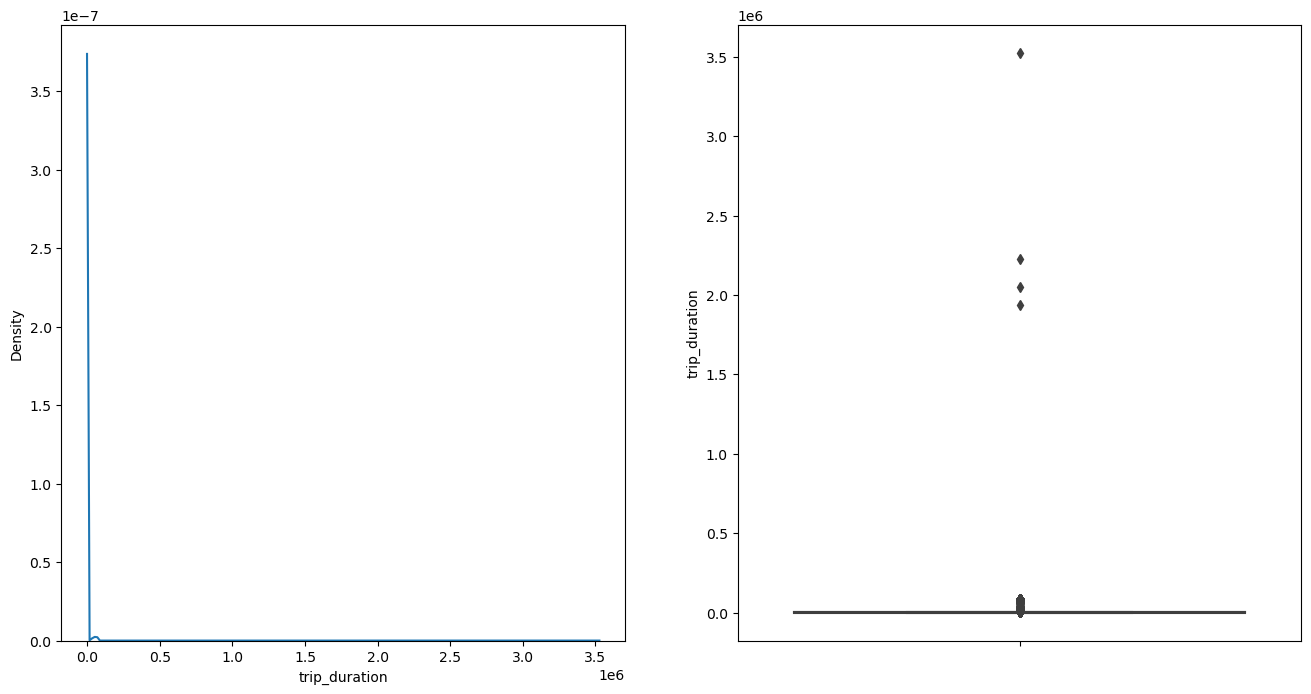

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
sns.kdeplot(df_train['trip_duration'], ax = axes[0])
sns.boxplot(y = df_train['trip_duration'], ax = axes[1])

In the density graph, an asymmetrical format to the right can be seen, visibly having a very high positive skewness.
As the concentration of these values tend to be small, the representation in logarithmic form can result in a better visualization of these data.

<AxesSubplot:>

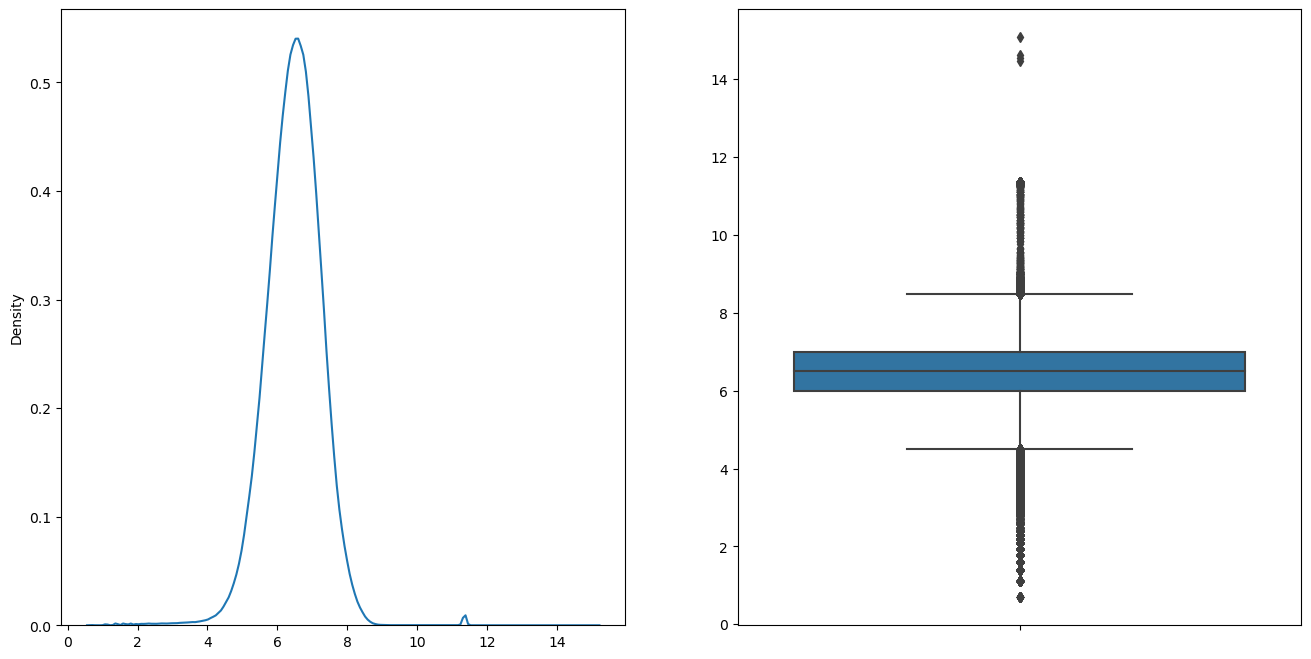

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
sns.kdeplot(np.log(df_train['trip_duration'].values+1),ax = axes[0])
sns.boxplot(y = np.log(df_train['trip_duration'].values+1), ax = axes[1])

Através da representação logarítmica, o gráfico passa a ter um formato mais parecido com uma distribuição normal, tendo a maior concentração de dados entre os valores de 4 e 9 (representando valores entre 55 e 8100 segundos). Existe também um pequeno pico de densidade entre os valores de 11 e 12 na escala logarítmica (valores entre 59900 e 162800 segundos), que são valores intuitivamente muito altos para uma viagem. Existem pequenas ondulações para valores menores que 3 na escala logarítmica (tempos de viagem menores que 20 segundos), que são valores inconsistentes de tempo de viagem.

Para construir um modelo mais robusto, os dados com trip_duration acima de 59900 segundos e menos de 20 segundos serão removidos.

In [13]:
df_train = df_train[df_train['trip_duration']<59900]
df_train = df_train[df_train['trip_duration']>20]

<AxesSubplot:ylabel='distance'>

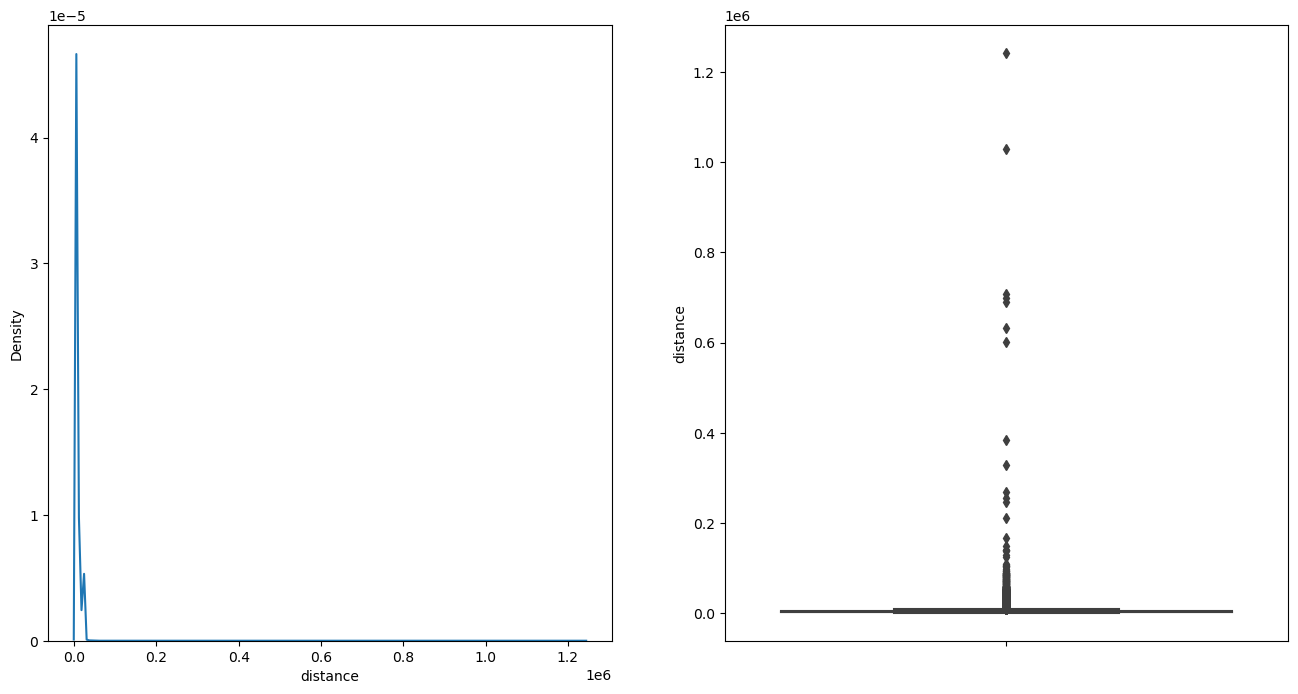

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
sns.kdeplot(df_train['distance'], ax = axes[0])
sns.boxplot(y = df_train['distance'], ax = axes[1])

Pode ser visto nos gráficos que esta variável tem o mesmo problema que 'trip_duration'. Com base nisso, será feita uma visualização em formato logarítmico.

<AxesSubplot:>

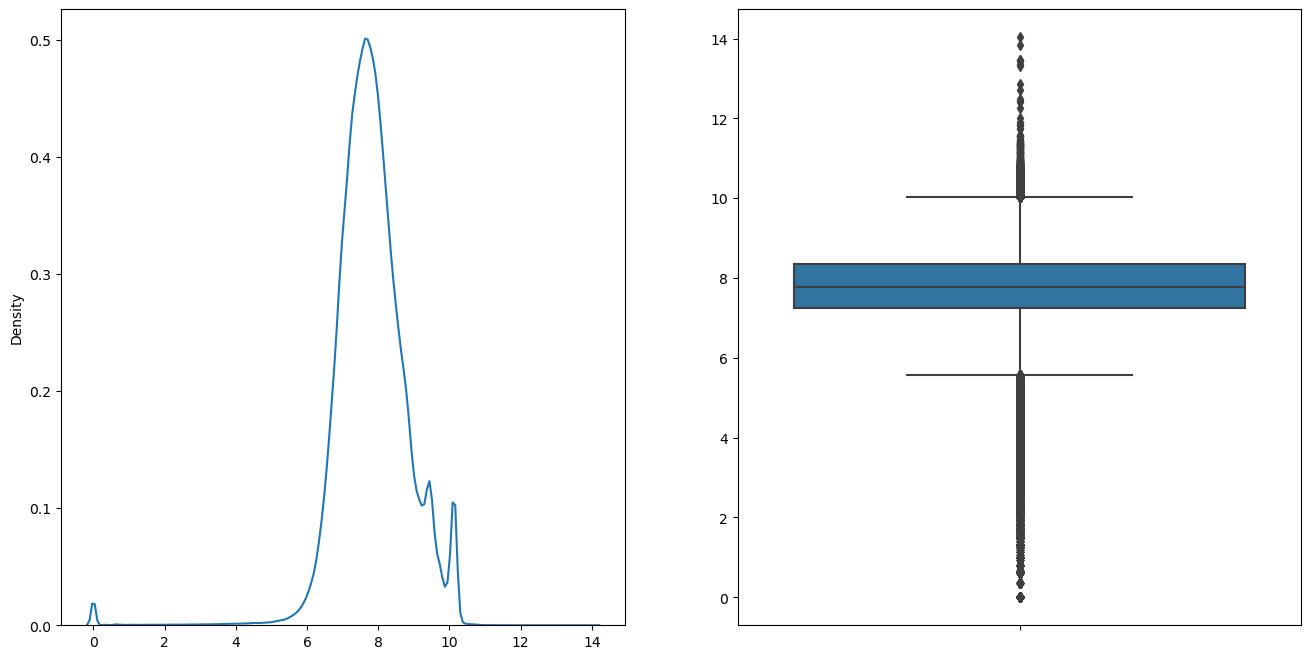

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
sns.kdeplot(np.log(df_train['distance'].values+1),ax = axes[0])
sns.boxplot(y = np.log(df_train['distance'].values+1), ax = axes[1])

No gráfico de densidade, nota-se certa semelhança com uma distribuição normal, sendo um pouco diferente para valores de distância logarítmica entre 9 e 10, onde há um pico de concentrações na mesma distância.

Observe também uma concentração de dados de distância próxima ou igual a 0 (aproximadamente 1 metro de distância). São valores muito baixos para uma viagem de carro, então provavelmente devem ter sido erros de armazenamento ou digitação do usuário ao solicitar a viagem, podendo ser considerados outliers.

Com base nisso, os valores de distância inferiores a 20 metros serão removidos.

In [16]:
df_train = df_train[df_train['distance']>20]

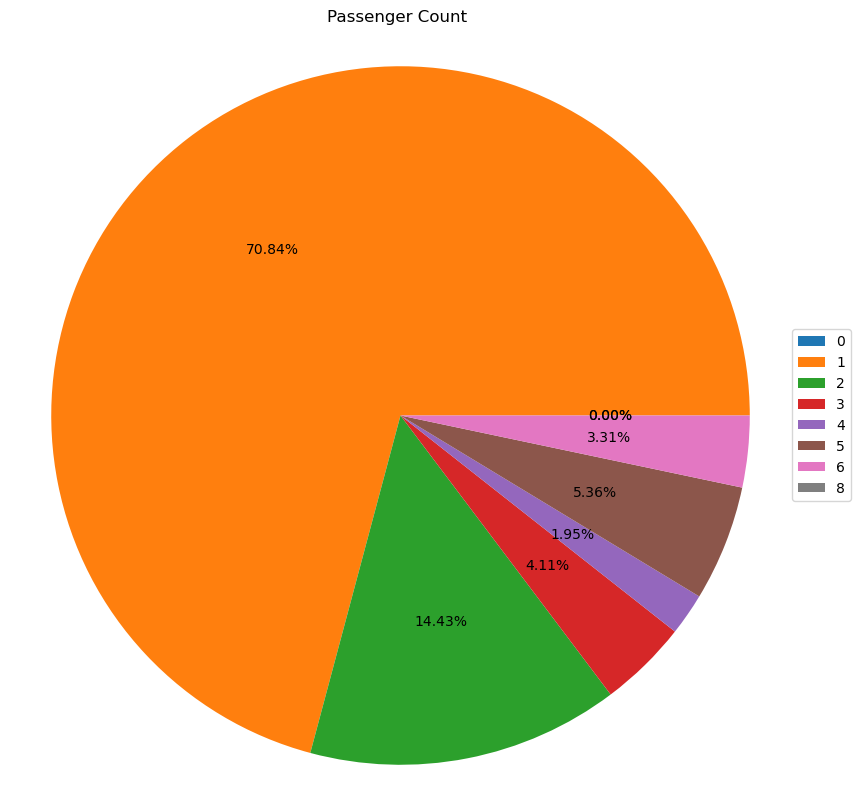

In [17]:
palette_color = sns.color_palette('pastel')[0:9]
passengers =  df_train.groupby(['passenger_count'])['passenger_count'].count()
labels =passengers.index

plt.subplots(figsize=(10, 10))
plt.title("Passenger Count")
plt.pie(passengers.values,autopct='%1.2f%%', radius=3)
plt.legend( labels, loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

Pode-se observar no gráfico que mais de 90% dos dados são de viagens com até 3 passageiros, sendo que quase 71% das viagens são feitas com um passageiro.

Observe que os dados onde inicialmente havia 9 passageiros por viagem foram removidos em processos anteriores.

Observa-se a presença de dados com número de passageiros igual a 0, porém em quantidade muito pequena. Como a quantidade de dados é pequena e é um valor inconsistente, esses dados serão removidos.

In [18]:
df_train = df_train[df_train['passenger_count']>0]

# **Análise Exploratória dos Dados (EDA)**

<AxesSubplot:xlabel='vendor_id', ylabel='count'>

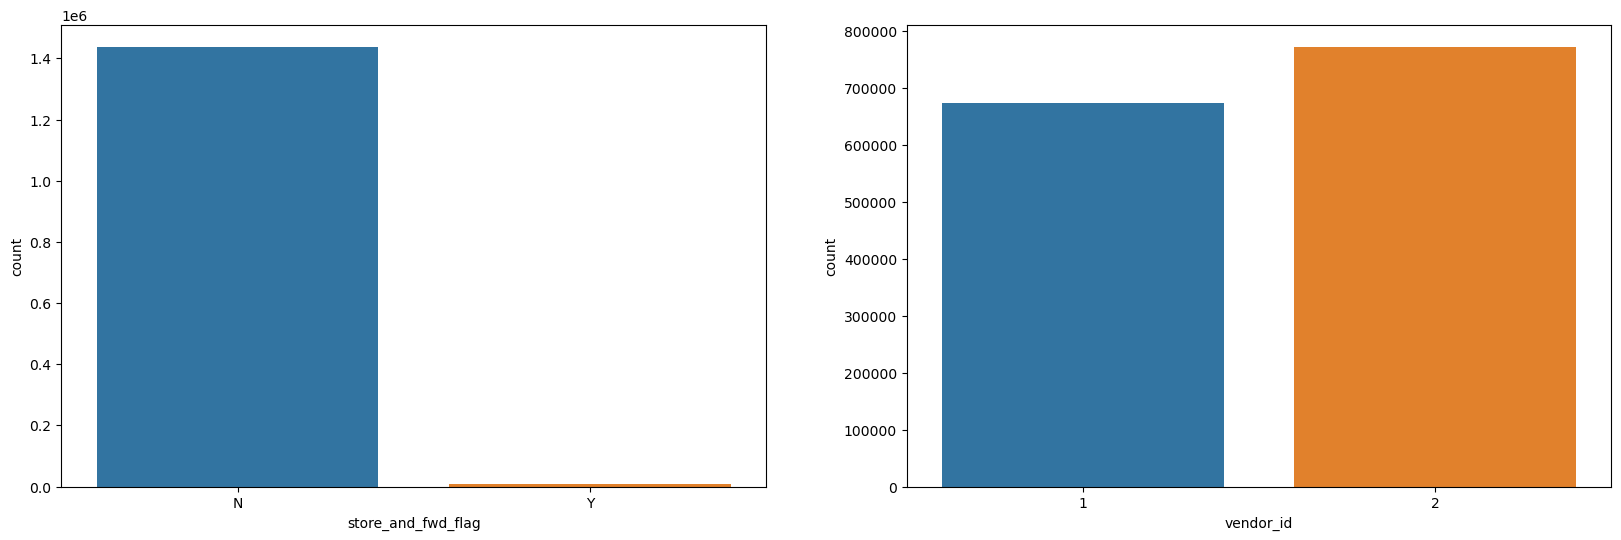

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=False)
sns.countplot(x = df_train['store_and_fwd_flag'],ax = axes[0])
sns.countplot(x = df_train['vendor_id'], ax = axes[1])

Observe que para o recurso 'store_and_fwd_flag' existem alguns registros onde a viagem ocorreu sem acesso à internet. Portanto é necessário verificar se 'trip_duration' ou 'distance' possuem valores inconsistentes com base nesta variável.

A partir do gráfico de 'vendor_id' pode-se ver que esse recurso está bem balanceado, mas possui uma quantidade maior de id 2.

Para uma melhor visualização dos dados as feições 'distance' e 'trip_duration' serão representadas em formato logarítmico

In [20]:
df_train['distance_log'] = np.log(df_train['distance']) 
df_train['trip_duration_log'] = np.log(df_train['trip_duration'])

<AxesSubplot:xlabel='passenger_count'>

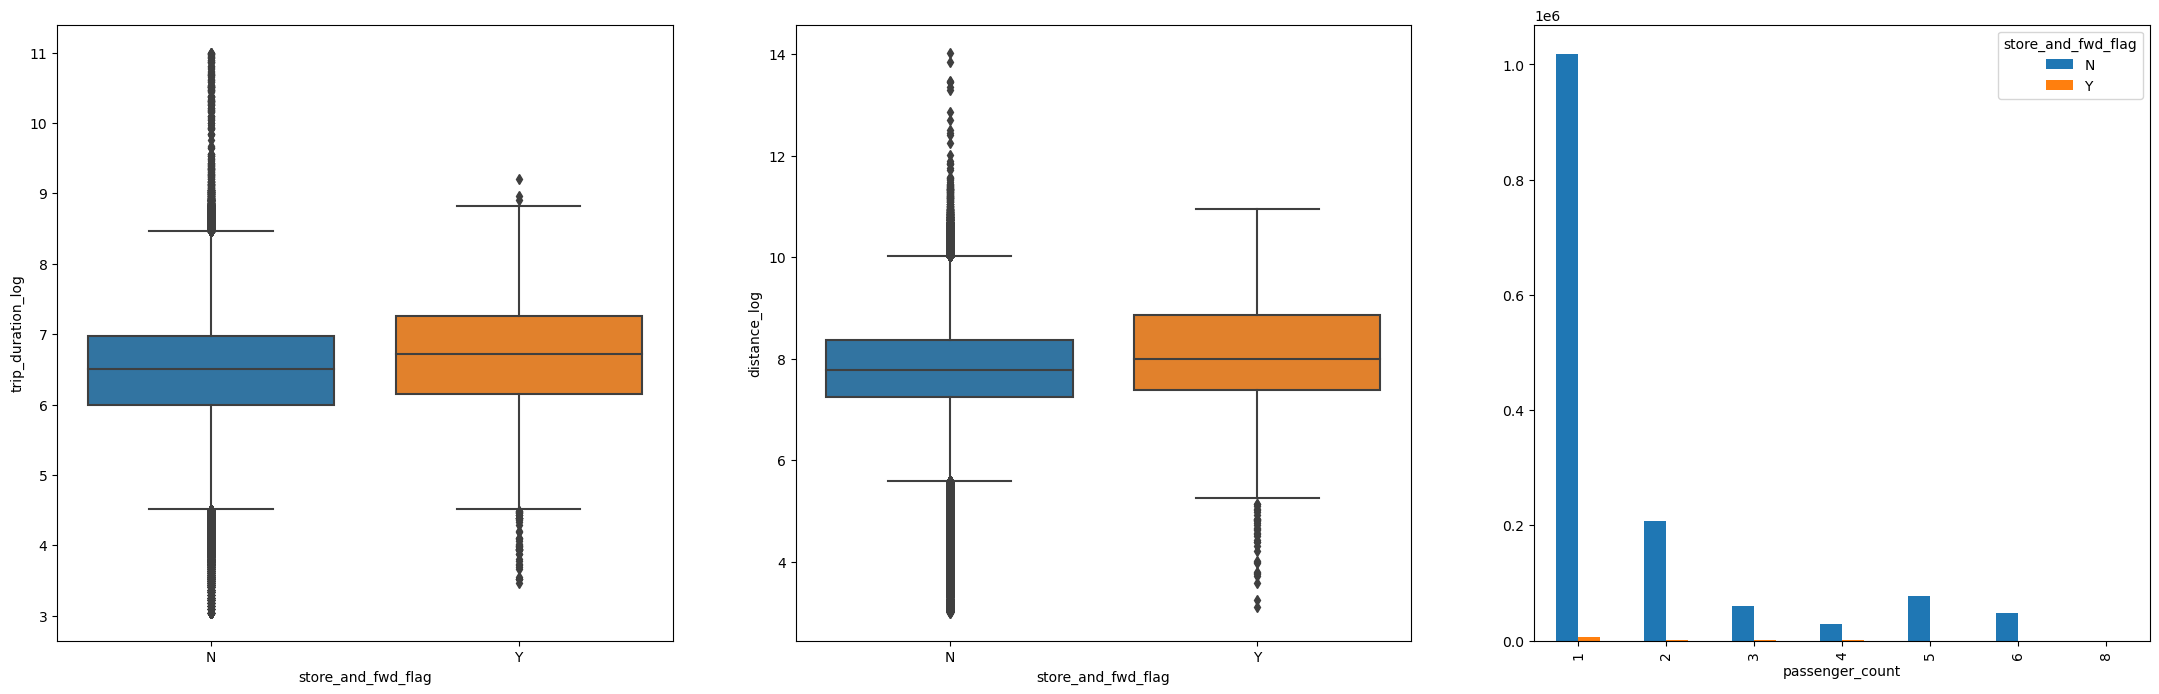

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(27, 8), sharey=False)
sns.boxplot(data = df_train,y='trip_duration_log', x  = 'store_and_fwd_flag', ax = axes[0])
sns.boxplot(data = df_train,y='distance_log', x  = 'store_and_fwd_flag', ax = axes[1])
df_train.groupby(['passenger_count']).store_and_fwd_flag.value_counts().unstack().plot.bar( ax = axes[2])

Pelos gráficos há uma pequena diferença entre viagens armazenadas e não armazenadas, mas não é muito expressiva. As viagens armazenadas por falta de acesso à internet são compostas por viagens realizadas com até 2 pessoas.

<AxesSubplot:xlabel='passenger_count'>

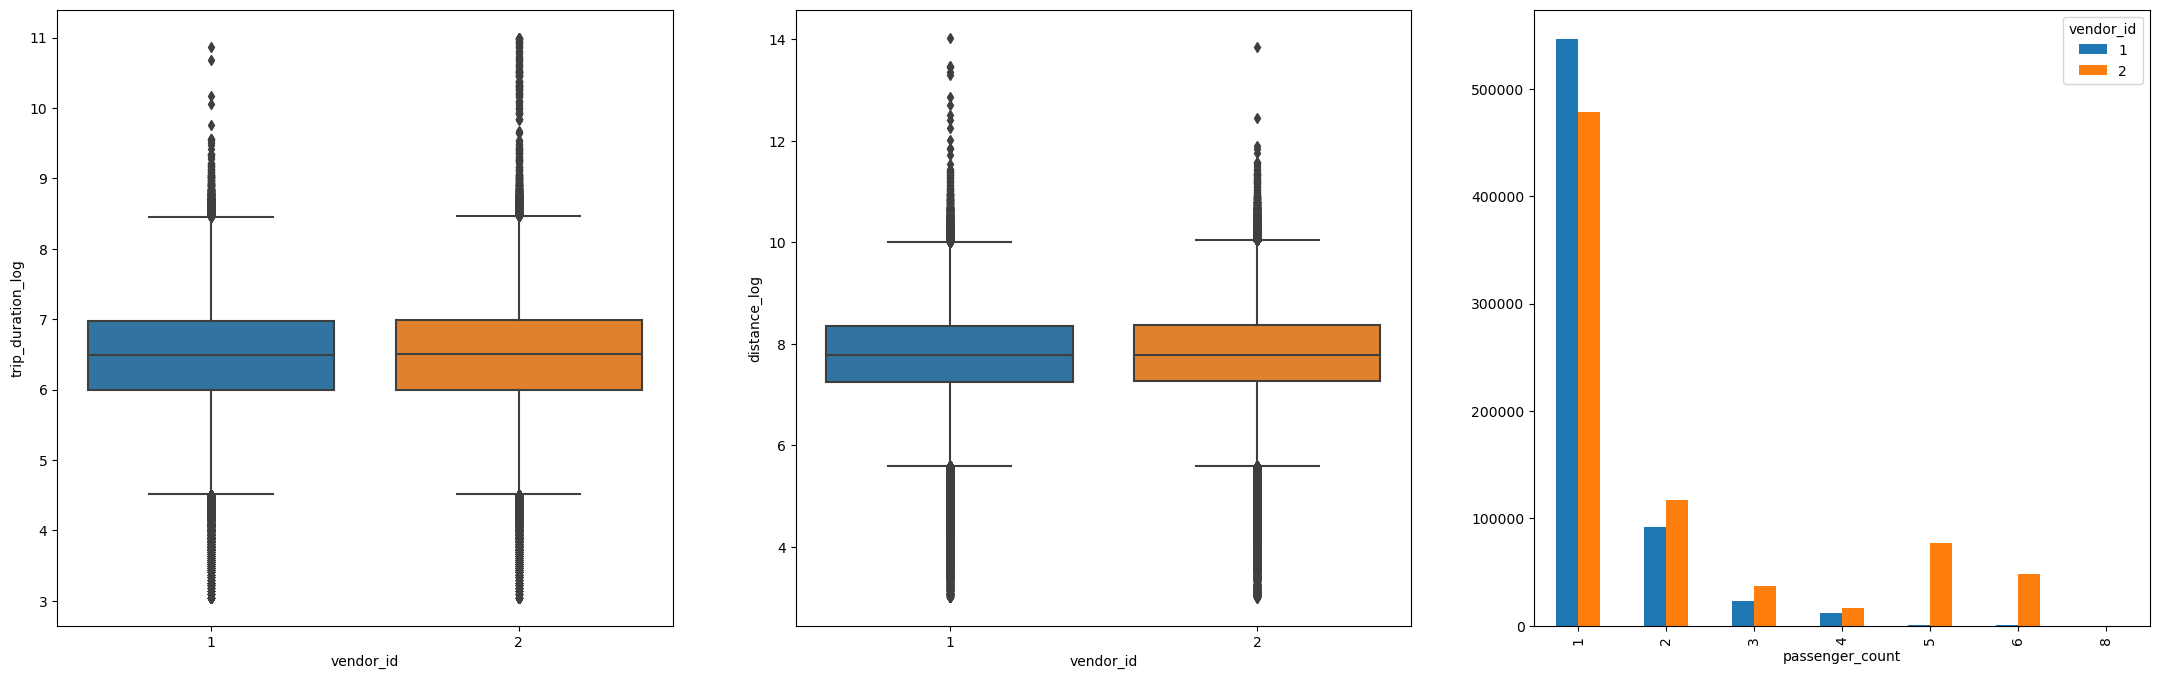

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(27, 8), sharey=False)
sns.boxplot(data = df_train,y='trip_duration_log', x  = 'vendor_id', ax = axes[0])
sns.boxplot(data = df_train,y='distance_log', x  = 'vendor_id', ax = axes[1])
df_train.groupby(['passenger_count']).vendor_id.value_counts().unstack().plot.bar( ax = axes[2])

Pelos gráficos não é possível identificar diferença na distribuição dos dados de 'vendor_id' em relação a 'trip_duration_log' e 'distance_log'.

Observe que o fornecedor 1 lida com viagens para até 4 pessoas, enquanto o fornecedor 2 lida com viagens para qualquer número de pessoas. Com base nisso é possível concluir que o id 1 é um táxi e o id 2 é uma limusine.

<AxesSubplot:xlabel='day_week_pickup', ylabel='count'>

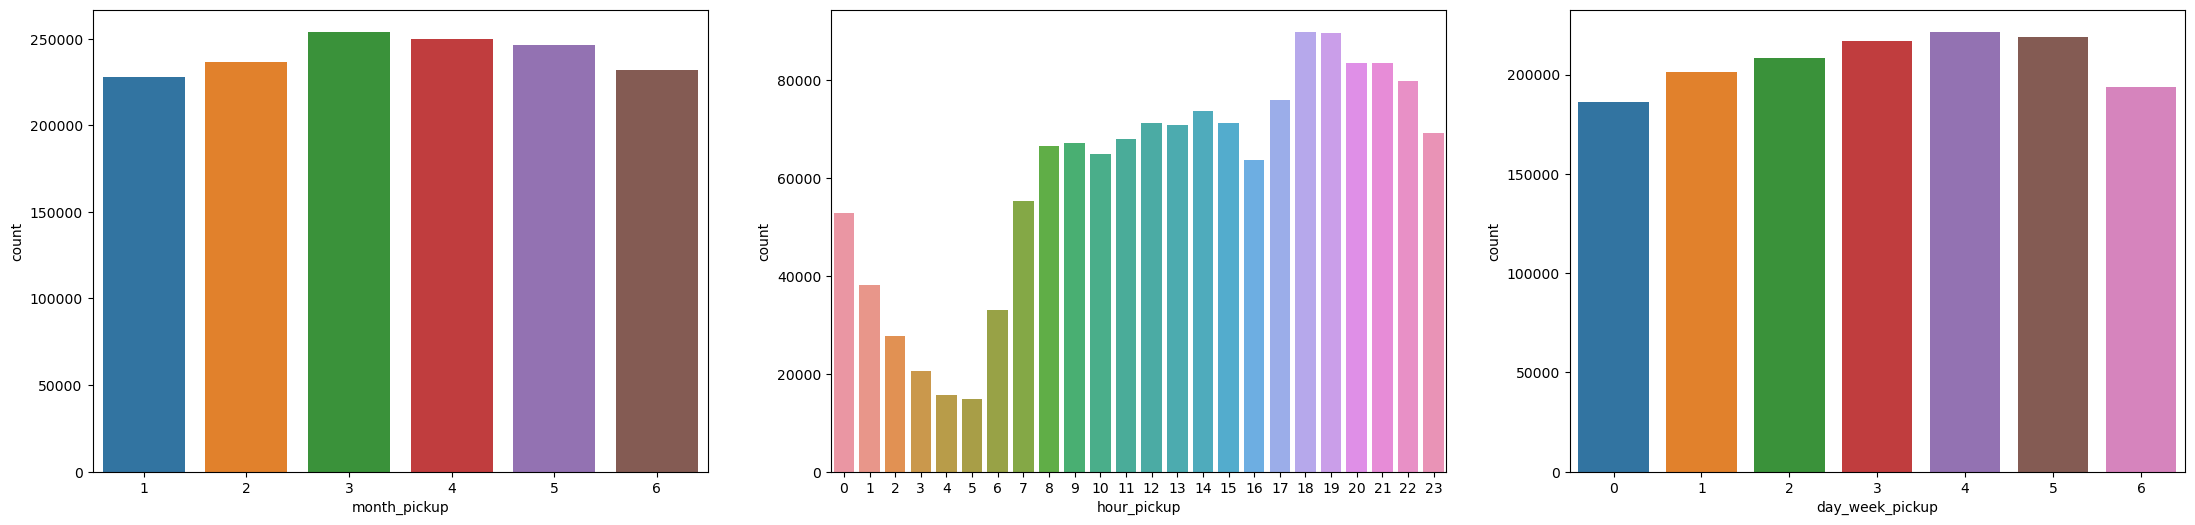

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(27, 6), sharey=False)
sns.countplot(x = df_train['month_pickup'], ax=axes[0])
sns.countplot(x = df_train['hour_pickup'], ax=axes[1])
sns.countplot(x = df_train['day_week_pickup'], ax=axes[2])

Pelo gráfico dos meses, pode-se observar que todos os meses apresentam valores próximos à quantidade de dados, sendo o menor valor em janeiro e o maior em março.

Pela tabela de horários de embarque, pode-se observar que poucas viagens ocorrem entre 00h00 e 05h00 e muitas viagens ocorrem entre 18h00 e 22h00.

A partir do gráfico de coleta dia semana, é possível observar que os dias da semana não possuem diferença relevante na quantidade de dados. Segunda e domingo são os dias com menos viagens e sábado e sexta são os dias com mais viagens.

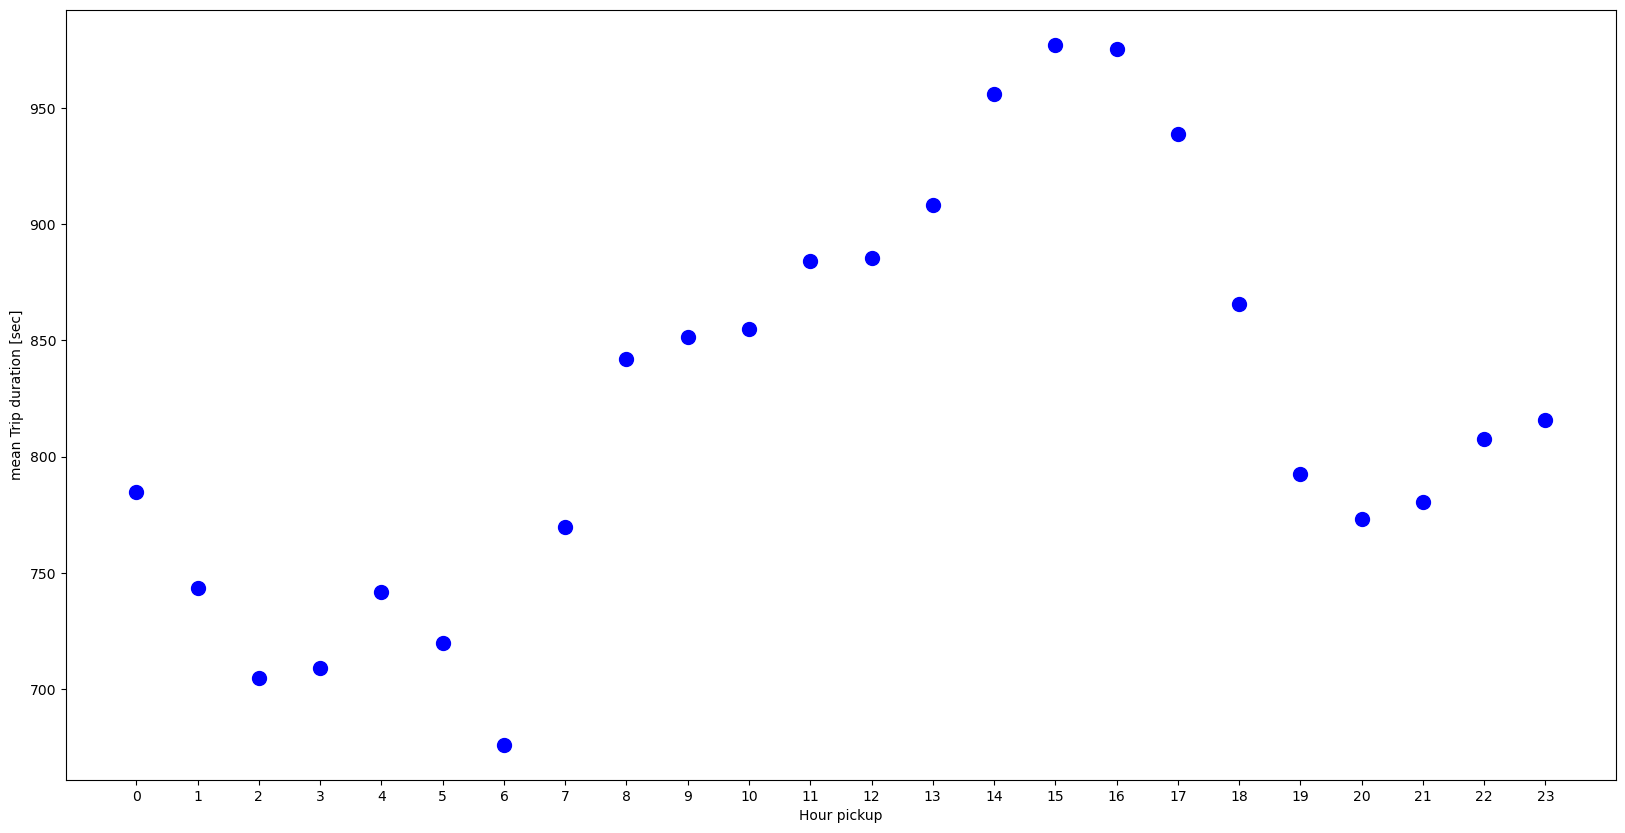

In [24]:
plt.figure(figsize=(20, 10))
plt.scatter(x=df_train.groupby(['hour_pickup'])['trip_duration'].mean().index, y = df_train.groupby(['hour_pickup'])['trip_duration'].mean(),s=100, color = 'b')
plt.xticks(df_train.groupby(['hour_pickup'])['trip_duration'].mean().index)
plt.ylabel('mean Trip duration [sec]')
plt.xlabel('Hour pickup');
plt.show()

Pelo gráfico é possível observar que as viagens realizadas entre 13h e 17h têm duração média superior a 900 segundos, sendo o período que possui média maior que todos os outros horários. Isso pode indicar que esse período é o de maior tráfego nessa cidade.

As viagens feitas entre 2h e 6h têm a menor duração média de viagem.

As viagens realizadas entre as 23h00 e as 05h00 parecem ter uma relação decrescente da duração da viagem com o passar do tempo.

Entre o período das 6h00 às 13h00 há um aumento gradativo na duração média da viagem.

Entre o período das 17:00 às 19:00 há uma diminuição gradual na duração média da viagem.

Com base nessas características, é possível inferir que esse recurso possui características importantes que podem ser relevantes na construção do modelo de previsão da 'trip_duration'.

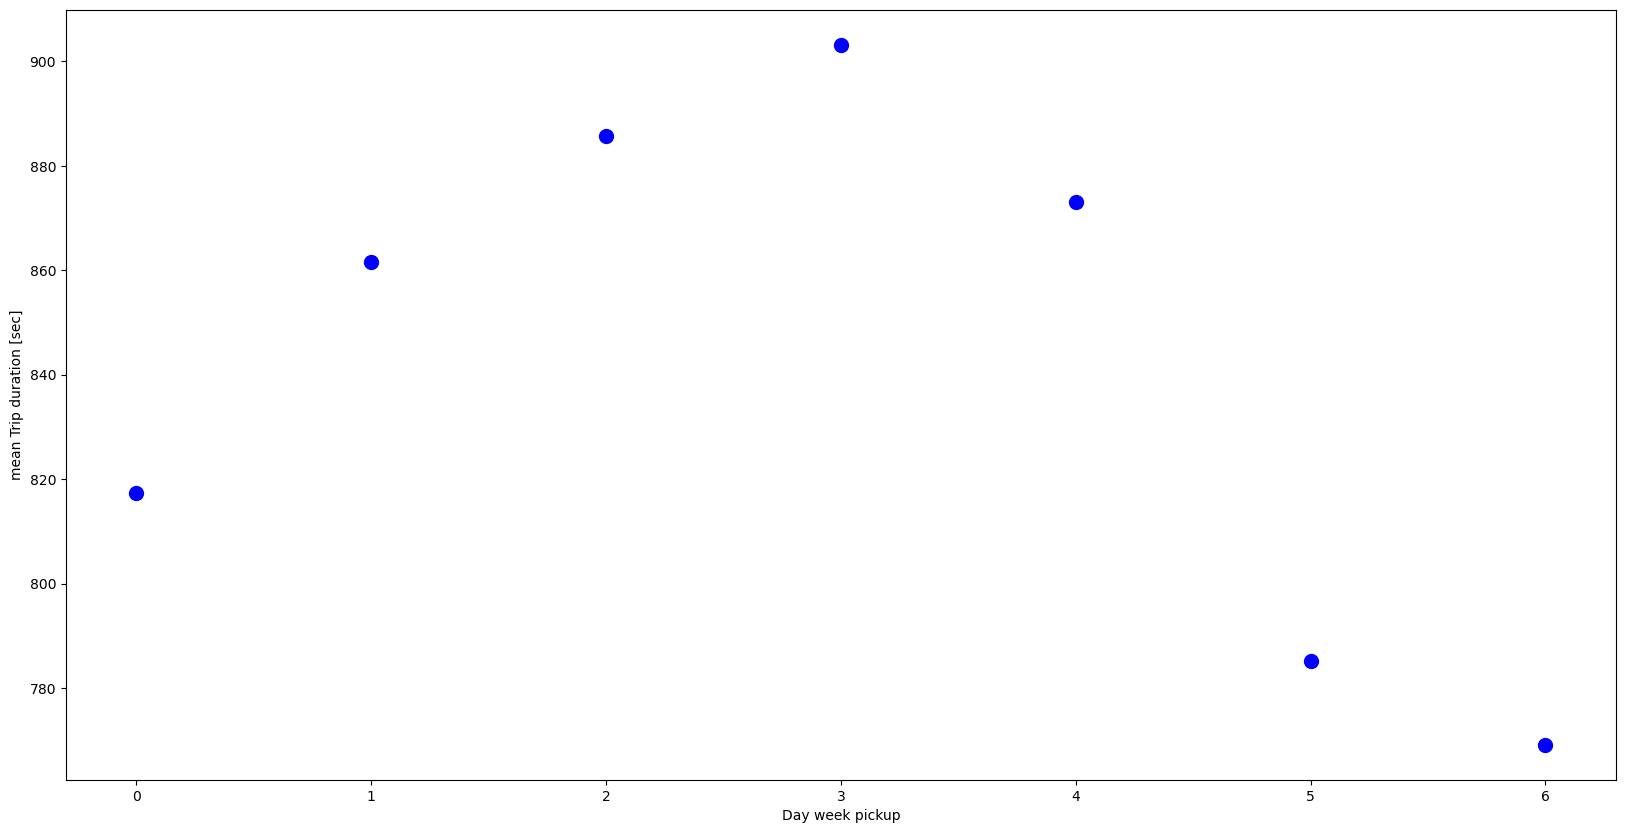

In [25]:
plt.figure(figsize=(20, 10))
plt.scatter(x=df_train.groupby(['day_week_pickup'])['trip_duration'].mean().index, y = df_train.groupby(['day_week_pickup'])['trip_duration'].mean(),s=100, color = 'b')
plt.xticks(df_train.groupby(['day_week_pickup'])['trip_duration'].mean().index)
plt.ylabel('mean Trip duration [sec]')
plt.xlabel('Day week pickup');
plt.show()

É possível identificar uma relação crescente entre a média de duração da viagem e os dias de segunda a quinta-feira.

É possível identificar uma relação decrescente entre a média de duração da viagem e os dias de quinta a domingo.

Os dias com os menores valores médios de duração da viagem são os finais de semana. Isso pode ser porque os fins de semana são menos movimentados ou porque nos fins de semana os sistemas de táxi e limusine são mais usados fora dos horários de pico. Para visualizar melhor, será criado um gráfico de contagem levando em consideração apenas o final de semana com base no tempo de viagem.

[Text(0.5, 1.0, 'Sunday countplot by hour pickup')]

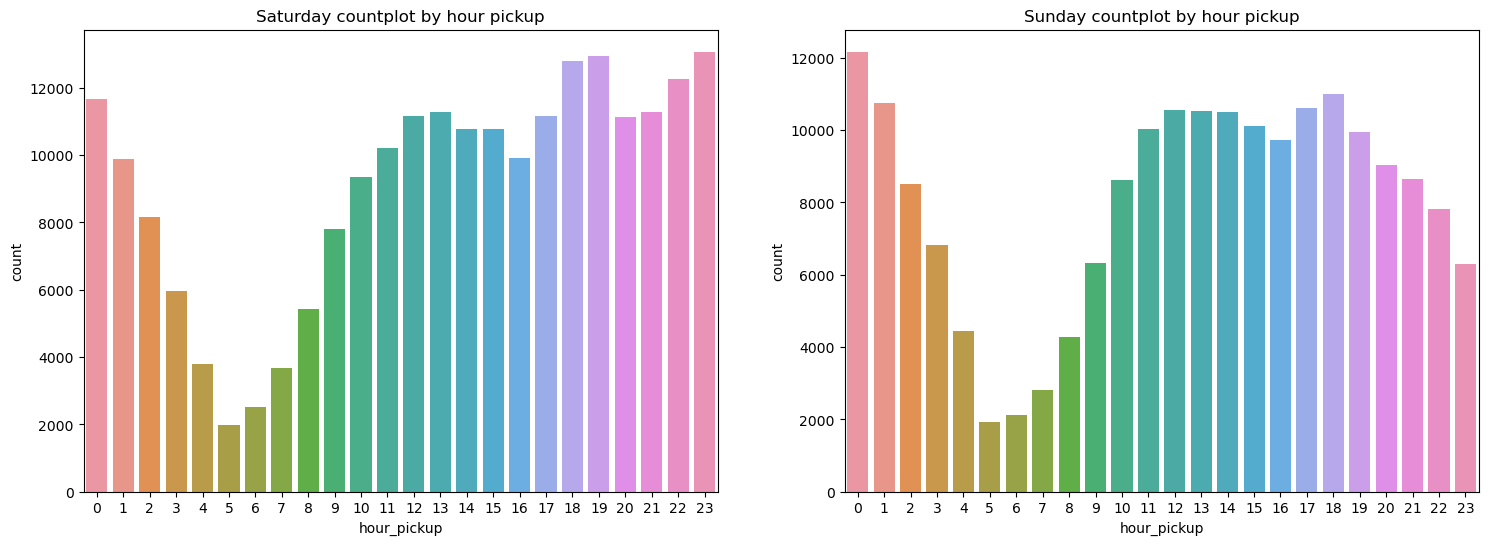

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
idx = df_train[df_train['day_week_pickup']==5].index
idx2 = df_train[df_train['day_week_pickup']==6].index
sns.countplot(x = df_train.loc[idx,'hour_pickup'], ax = axes[0]).set(title='Saturday countplot by hour pickup')
sns.countplot(x = df_train.loc[idx2,'hour_pickup'], ax = axes[1]).set(title='Sunday countplot by hour pickup')

Há maior concentração de dados entre 18h e 1h no sábado e picos entre meia-noite e 1h no domingo.
Como esses horários noturnos têm um valor médio menor de tempo de viagem, pode ter sido um dos fatores que tornaram a média de dias de fim de semana menor.

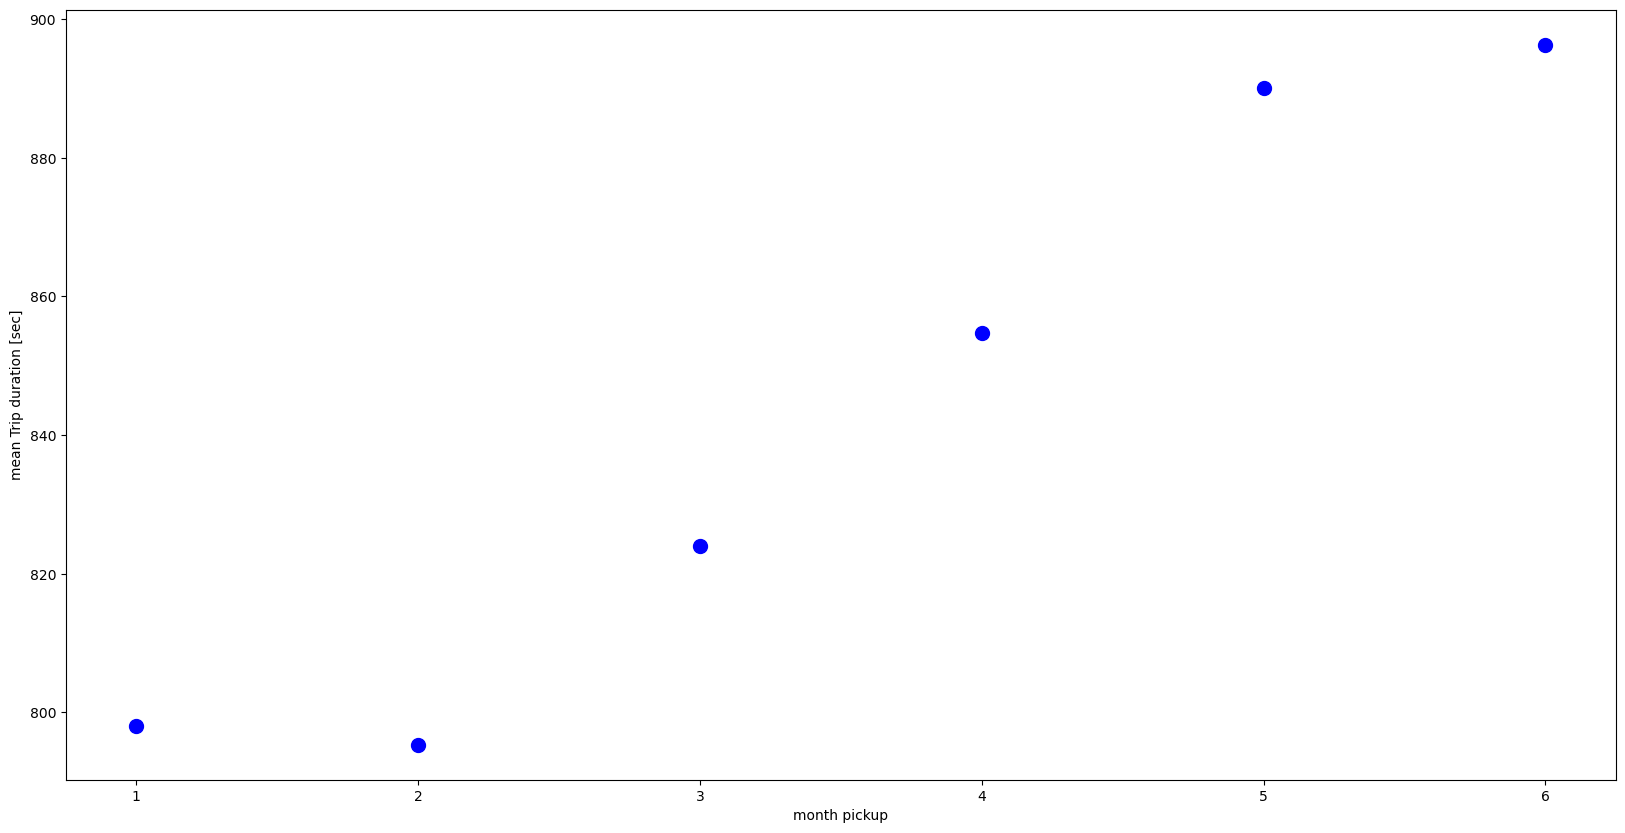

In [27]:
plt.figure(figsize=(20, 10))
plt.scatter(x=df_train.groupby(['month_pickup'])['trip_duration'].mean().index, y = df_train.groupby(['month_pickup'])['trip_duration'].mean(),s=100, color = 'b')
plt.xticks(df_train.groupby(['month_pickup'])['trip_duration'].mean().index)
plt.ylabel('mean Trip duration [sec]')
plt.xlabel('month pickup');
plt.show()

Existe uma relação linear crescente entre os meses e o valor médio da duração das viagens.

Como o ciclo de um ano de análise dos dados não foi concluído, pode ser que essa informação não seja tão relevante, pois pode ser um efeito cíclico e não um efeito crescente ao longo dos meses.

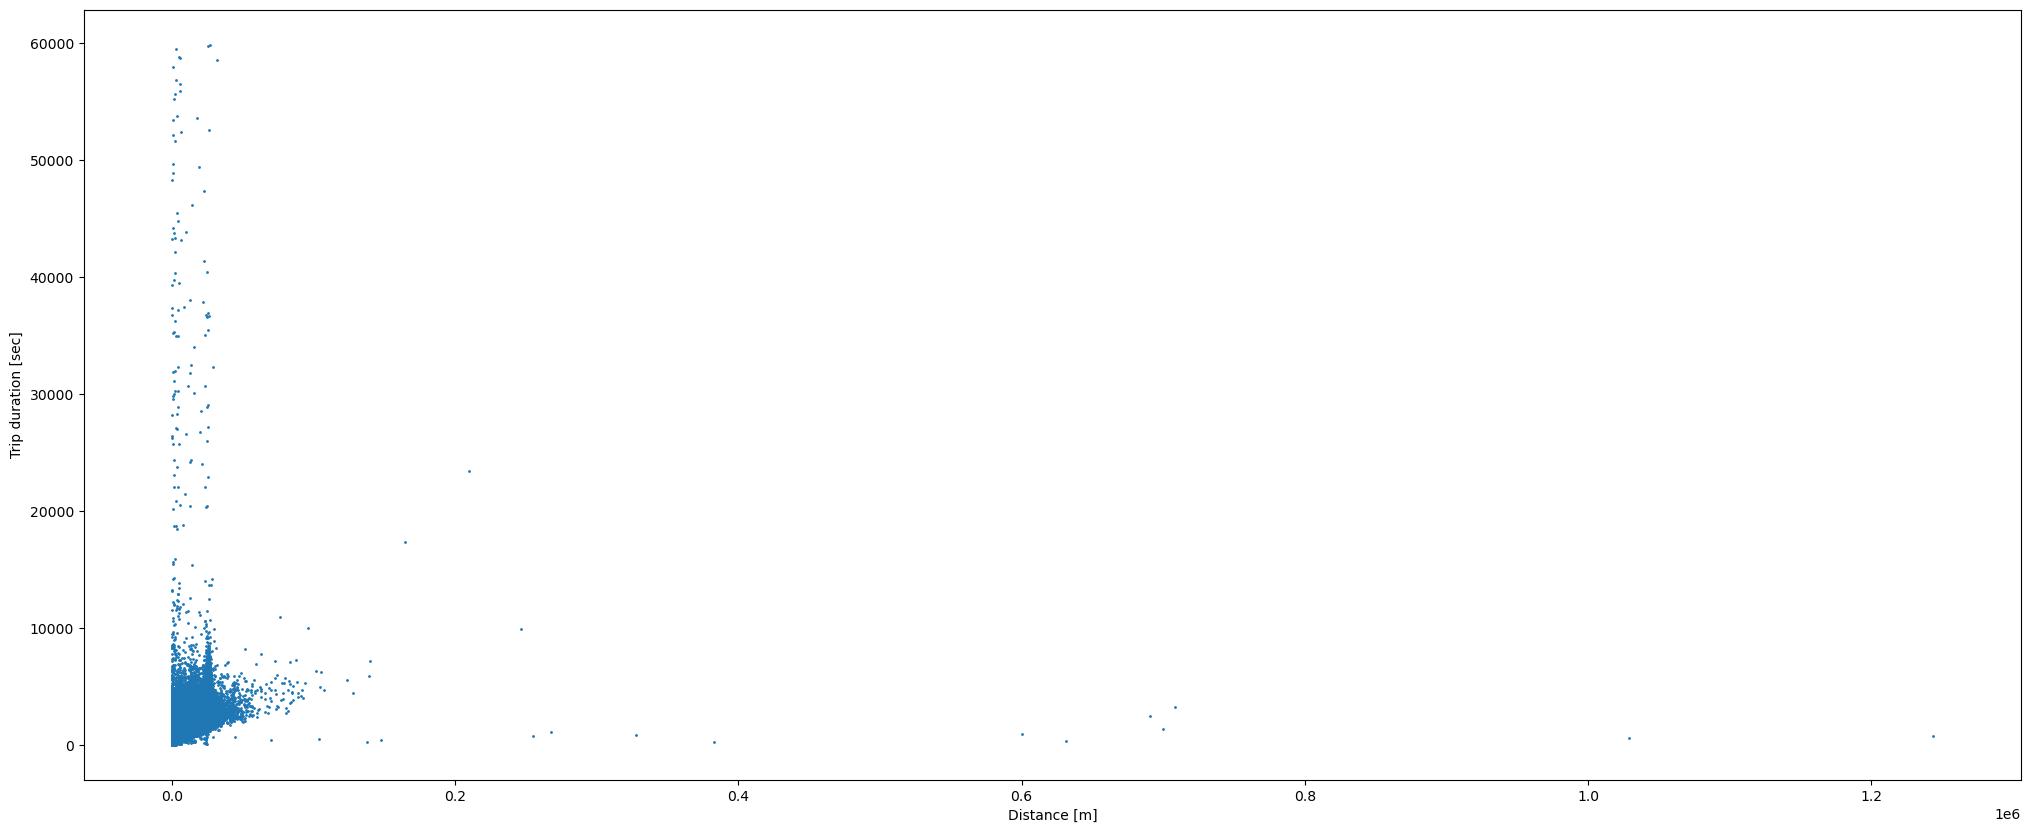

In [28]:
plt.figure(figsize=(25, 10))
scatter = plt.scatter(x = df_train['distance'], y = df_train['trip_duration'], s = 1)
plt.xlabel('Distance [m]')
plt.ylabel('Trip duration [sec]');
plt.show()

O gráfico mostra uma certa linearidade entre as variáveis, mas devido à escala das variáveis, não é possível visualizar os dados corretamente. Para isso, a plotagem será refeita em escala logarítmica.

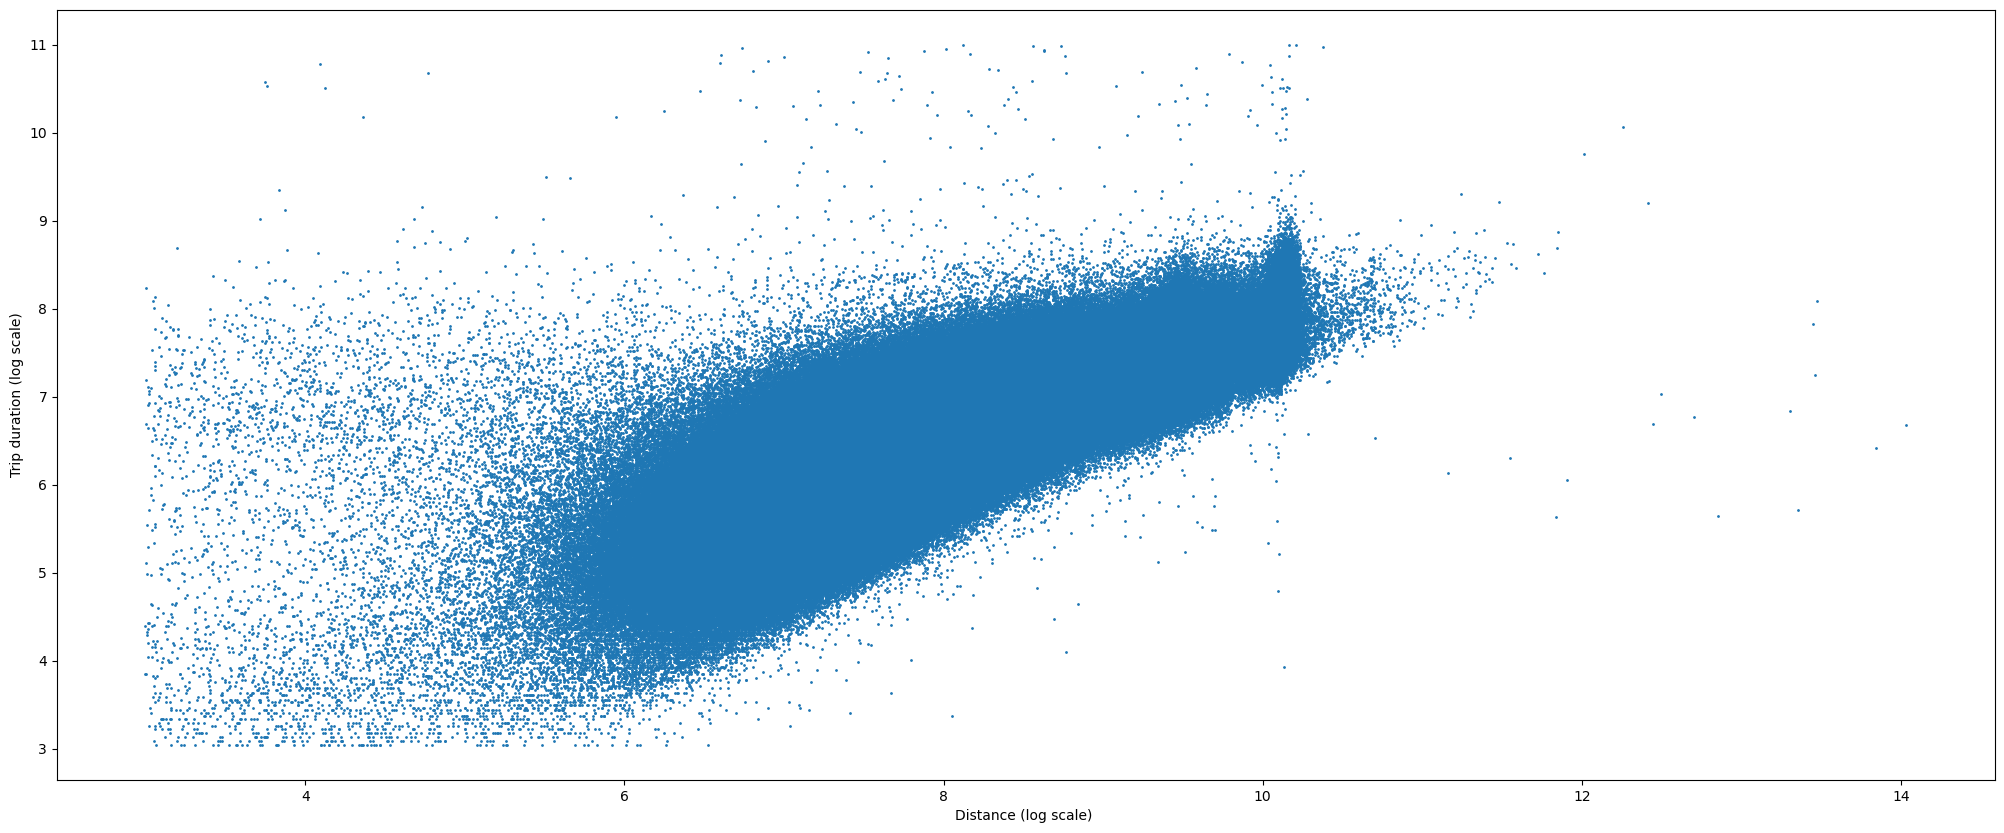

In [29]:
plt.figure(figsize=(25, 10))
scatter = plt.scatter(x = df_train['distance_log'], y = df_train['trip_duration_log'], s = 1)
plt.xlabel('Distance (log scale) ')
plt.ylabel('Trip duration (log scale)');
plt.show()

Neste gráfico, pode-se observar uma linearidade mais expressiva do que no gráfico anterior.

Devido a esse formato mais expressivo e seu formato mais próximo de uma distribuição normal para as duas variáveis visualizadas anteriormente, essas variáveis serão utilizadas no formato logarítmico para aplicação do modelo e posteriormente serão convertidas para a escala normal para avaliação do métricas do modelo.

In [30]:
df_train.drop(columns = ['trip_duration','distance'], inplace = True)

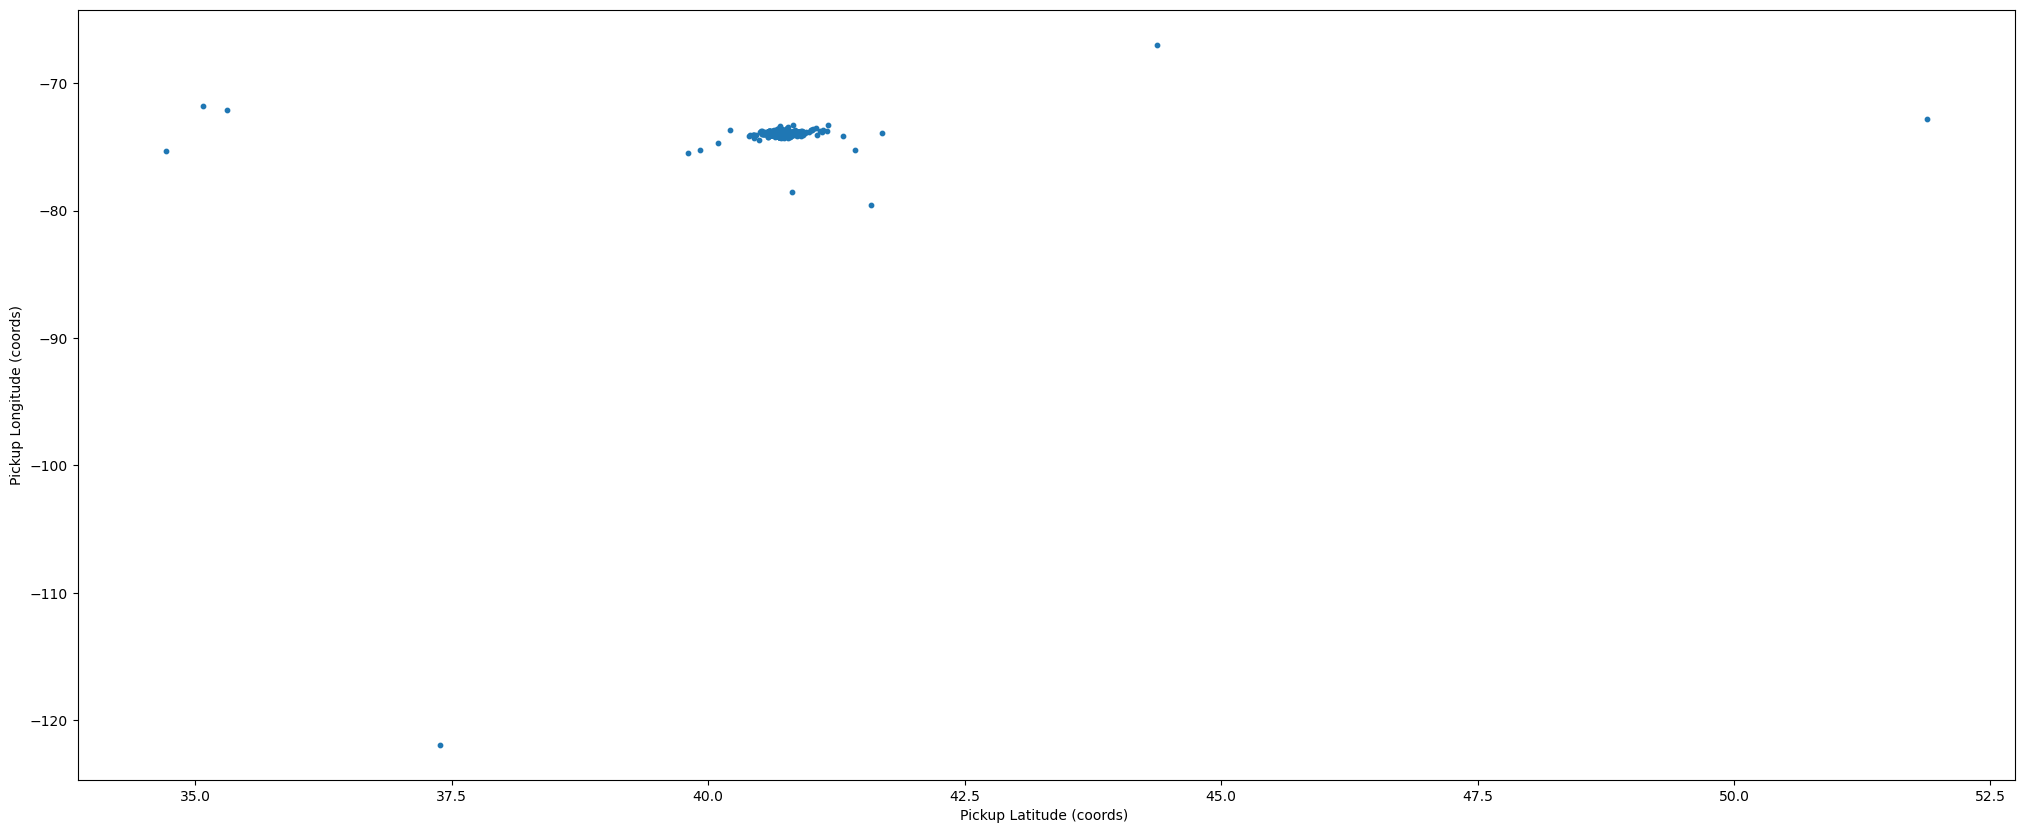

In [31]:
plt.figure(figsize=(25, 10))
scatter = plt.scatter(x = df_train['pickup_latitude'], y = df_train['pickup_longitude'], s = 10)
plt.xlabel('Pickup Latitude (coords) ')
plt.ylabel('Pickup Longitude (coords)');
plt.show()

Observando o gráfico das coordenadas de coleta, é possível notar alguns pontos muito distantes da região principal dos dados. Como se tratam de dados muito distantes dos pólos de viagem analisados, pontos acima de 42,5 latitude, menores que 37,5 latitude, maiores que -70 longitude e menores que -76 longitude serão removidos.

In [32]:
df_train = df_train[df_train['pickup_latitude']>37.5]
df_train = df_train[df_train['pickup_latitude']<42.5]
df_train = df_train[df_train['pickup_longitude']<-70]
df_train = df_train[df_train['pickup_longitude']>-75]

# **Correlação**

Para evitar problemas de multicolinearidade, dois tipos de correlação serão avaliados para cada par de atributos: a correlação de Pearson e a correlação de postos de Spearman.
Como não existe uma literatura muito clara para valores de correlação 'aceitáveis' que evitem a multicolinearidade, valores maiores que 0,8 de correlação serão definidos como valores de corte a serem removidos.

In [33]:
# Pearson correlation
aux_df = df_train.drop(columns = ['trip_duration_log'])
corr_pearson = aux_df.corr(method = 'pearson')
cols1 = corr_pearson.index
cols2 = corr_pearson.columns

corr_spear_rank  =  np.zeros(shape=(len(cols1), len(cols2)))
for i in range(0,len(cols1)):
    for j in range(0,len(cols2)):
        corr_spear_rank[i,j] = spearmanr(aux_df[cols1[i]], aux_df[cols2[j]])[0]
        
corr_spear_rank = pd.DataFrame(corr_spear_rank, columns = cols2, index = cols1)

<AxesSubplot:>

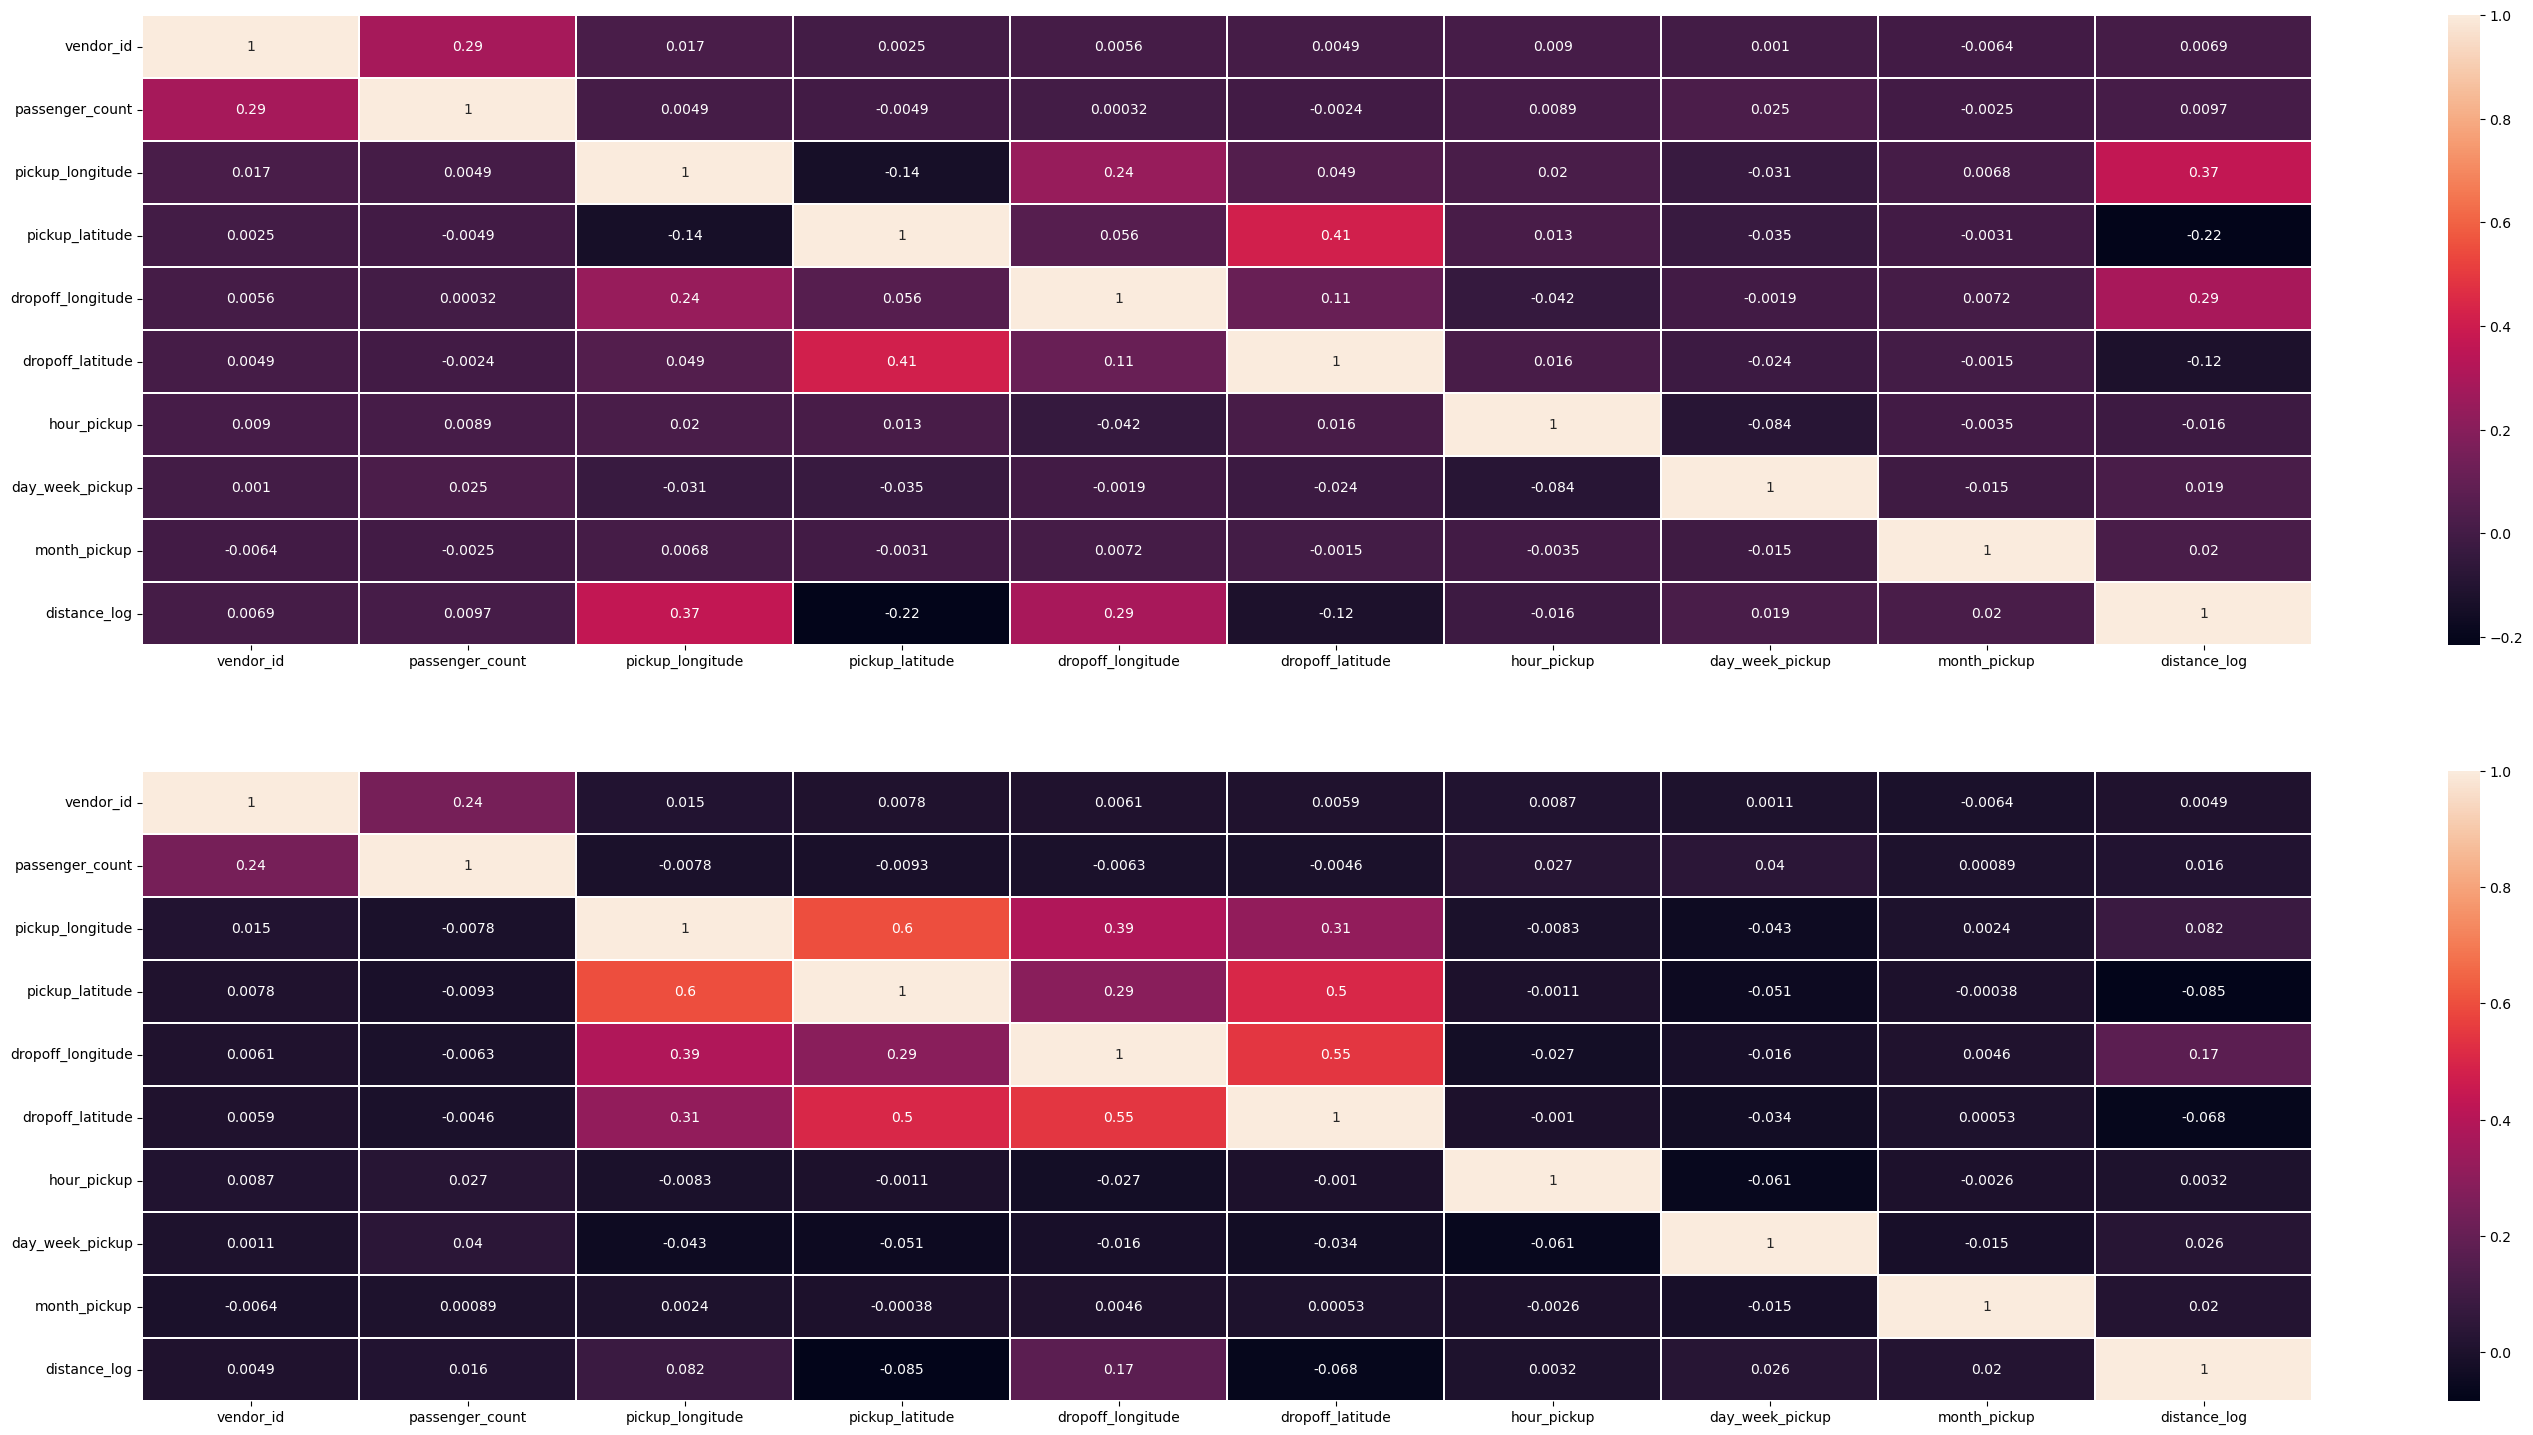

In [34]:
fig, axes = plt.subplots(2,1, figsize=(35,18))

sns.heatmap(corr_pearson, annot=True,linewidths=.1, ax = axes[0])
sns.heatmap(corr_spear_rank, annot=True,linewidths=.1, ax = axes[1])

Examinando as matrizes de correlação de postos de Pearson e Spearman, percebe-se que nenhum valor de correlação é maior que o valor de corte inicialmente definido, portanto nenhuma variável será removida.

# **Implementação do modelo**

Antes da aplicação do modelo de regressão, será aplicada a normalização dos dados não categóricos, visando aumentar o desempenho do modelo e evitar que o algoritmo viesse para variáveis de ordem de grandeza superior.

Durante o aprendizado do modelo, o método de validação cruzada será aplicado, a fim de avaliar a generalização do modelo.

In [35]:
#  Scaling data
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

df_train.index = range(len(df_train.index))

cols1 = ['vendor_id','store_and_fwd_flag']
cols2 = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance_log','hour_pickup','day_week_pickup','month_pickup']


train_scaler = pd.DataFrame(scaler.fit_transform(df_train.loc[:,cols2]), columns = cols2)
df_train['store_and_fwd_flag'] = label_encoder.fit_transform(df_train['store_and_fwd_flag']) 
df_train_scaler = pd.concat([train_scaler, df_train.loc[:,cols1]], axis=1)

In [36]:
X = df_train_scaler
y = df_train['trip_duration_log']
kf = KFold(n_splits = 5, shuffle = False)
#X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=.2,random_state =0, Shuffle = False)

# LGBMRegressor

Como modelo de regressão será utilizado o LightGBM, sendo um modelo de aprendizado de máquina que possui um ótimo desempenho para resolução de problemas de regressão.
Nela serão feitas duas avaliações, uma com o modelo padrão e outra aprimorando os hiperparâmetros deste modelo, visando aumentar a precisão do modelo.

In [37]:
model = lgb.LGBMRegressor(random_state=0)
rmsle = []
rmse = []
# K-fold for cross validation
for i, (tr, ts) in enumerate(kf.split(X)):
    X_train,y_train = X.iloc[tr], y.iloc[tr]
    X_val,y_val = X.iloc[ts], y.iloc[ts]
    model.fit(X_train,y_train, eval_metric = mean_squared_log_error)
    ypred = model.predict(X_val,start_iteration=-1)
    msle_v = mean_squared_log_error(np.exp(y_val), np.exp(ypred), squared = False)
    rmsle.append(msle_v)
    mse_v = mean_squared_error(np.exp(y_val), np.exp(ypred), squared = False)
    rmse.append(mse_v)
    
print("RMSE mean : {:.2f}".format(np.mean(rmse)))

print("RMSLE mean: {:.5f}".format(np.mean(rmsle)))

RMSE mean : 455.96
RMSLE mean: 0.35493


Um valor de RMSLE aceitável para mim seria em torno de 0,3, mas percebe-se um valor de RMSLE obtido de 0,3549, ficando um pouco acima do aceitável.

In [38]:
def Objective_LGBM(trial):
    
    LGBM__num_leaves = trial.suggest_int('LGBM__num_leaves',400,1000)
    LGBM__learning_rate = trial.suggest_float('LGBM__learning_rate',0.01,0.2)
    LGBM__n_estimators = trial.suggest_int('LGBM__n_estimators',500,900)
    LGBM__subsample = trial.suggest_float('LGBM__subsample',0.8,1)
    LGBM__colsample_bytree = trial.suggest_float('LGBM__colsample_bytree',0.8,1)
    
    
    params = {
        'LGBM__boosting_type': 'gbdt',
        'LGBM__num_leaves' : LGBM__num_leaves,
        'LGBM__learning_rate' : LGBM__learning_rate,
        'LGBM__n_estimators' : LGBM__n_estimators,
        'LGBM__subsample' : LGBM__subsample,
        'LGBM__colsample_bytree' : LGBM__colsample_bytree, 
    }
    
    msle = []
    
    # K-fold for cross validation
    for i, (tr, ts) in enumerate(kf.split(X)):
        X_train,y_train = X.iloc[tr], y.iloc[tr]
        X_val,y_val = X.iloc[ts], y.iloc[ts]
        model = model_LGBM.set_params(**params)
        model.fit(X_train,y_train, LGBM__eval_metric = mean_squared_log_error)
        ypred = model.predict(X_val,start_iteration=-1)
        msle_v = mean_squared_log_error(np.exp(y_val), np.exp(ypred), squared = False)
        msle.append(msle_v)
    
    return np.round(np.mean(msle),decimals = 4)

In [39]:
%%time
LGBMReg2 = lgb.LGBMRegressor
model_LGBM = Pipeline([('LGBM', LGBMReg2(random_state=0))])
study_LGBM = optuna.create_study(directions = ["minimize"])
study_LGBM.optimize(Objective_LGBM, n_trials = 30)

[I 2023-02-02 22:51:31,454] A new study created in memory with name: no-name-cbb4d0c0-f78b-4980-9f22-662fe7c0a470
[I 2023-02-02 22:55:22,295] Trial 0 finished with value: 0.3136 and parameters: {'LGBM__num_leaves': 621, 'LGBM__learning_rate': 0.0725311084452272, 'LGBM__n_estimators': 647, 'LGBM__subsample': 0.9963362816423287, 'LGBM__colsample_bytree': 0.938055046392314}. Best is trial 0 with value: 0.3136.
[I 2023-02-02 23:00:37,747] Trial 1 finished with value: 0.3164 and parameters: {'LGBM__num_leaves': 886, 'LGBM__learning_rate': 0.030590824844075076, 'LGBM__n_estimators': 581, 'LGBM__subsample': 0.9614201820558366, 'LGBM__colsample_bytree': 0.9143537115276192}. Best is trial 0 with value: 0.3136.
[I 2023-02-02 23:07:22,091] Trial 2 finished with value: 0.3223 and parameters: {'LGBM__num_leaves': 734, 'LGBM__learning_rate': 0.013535591870024928, 'LGBM__n_estimators': 715, 'LGBM__subsample': 0.919624306588211, 'LGBM__colsample_bytree': 0.9533783293702495}. Best is trial 0 with value

CPU times: total: 12h 57min 50s
Wall time: 2h 40min 20s


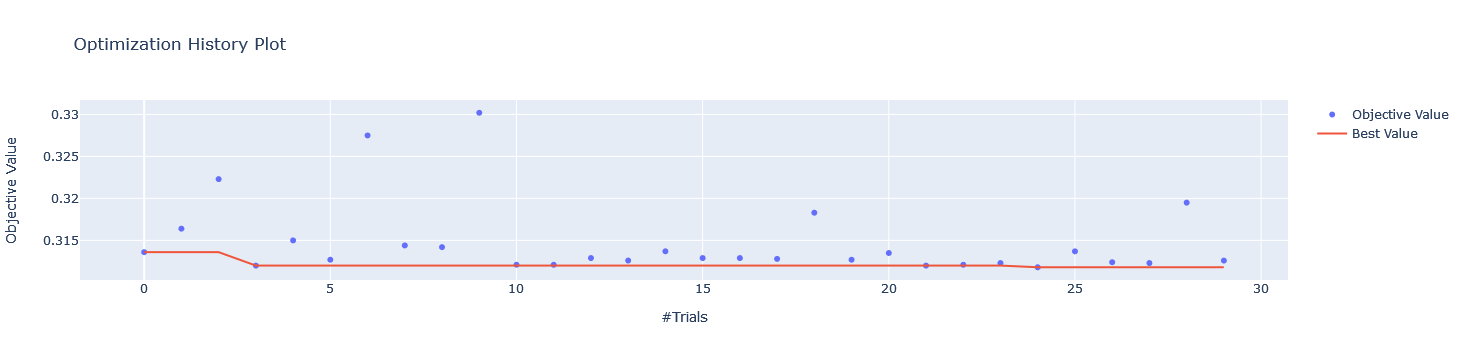

In [40]:
plot_optimization_history(study_LGBM)

Com o processo de otimização, observa-se uma melhora de aproximadamente 0,04 no valor do RMSLE, mostrando que a otimização foi significativa. Observa-se também que o resultado final obtido foi de 0,3112, valor um pouco superior ao definido inicialmente.

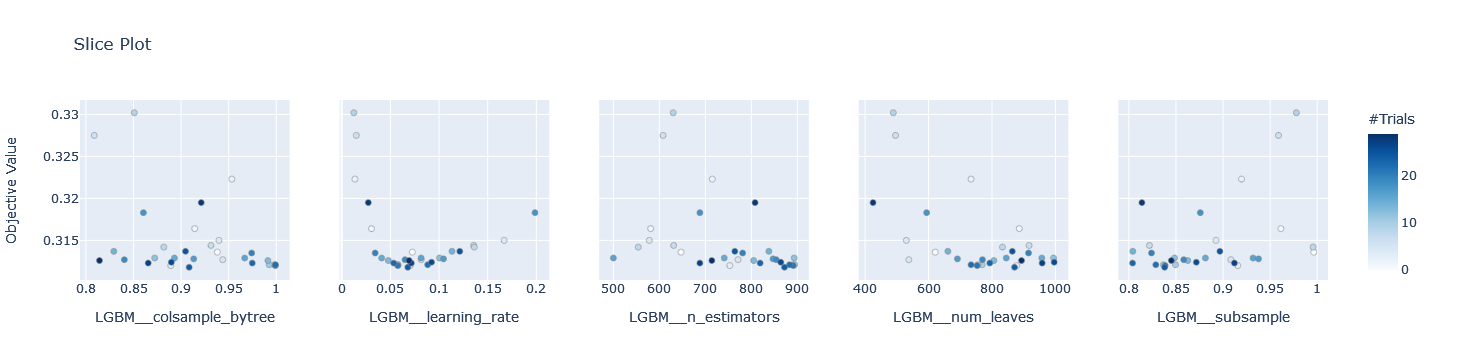

In [41]:
plot_slice(study_LGBM)

Dos gráficos de variação dos parâmetros, nenhuma variável tendeu aos limites inicialmente estabelecidos à medida que ocorreu a otimização, excluindo a variável 'colsample_bytree', cujo valor máximo possível é 1. Isso é uma indicação de que a otimização foi realizada corretamente e nenhum parâmetro precisa ser expandido em uma nova otimização para melhorar ainda mais o desempenho do modelo.

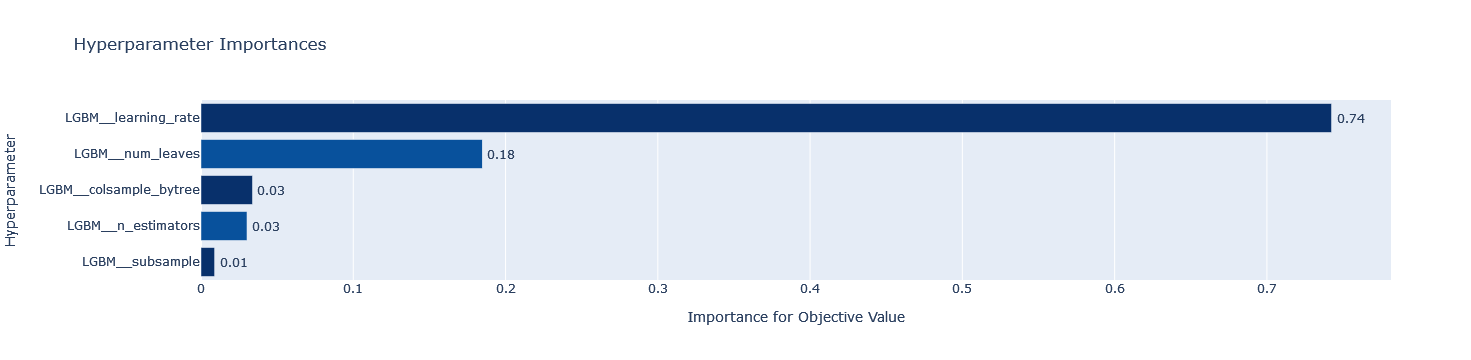

In [42]:
plot_param_importances(study_LGBM)

Observa-se que a variável 'learning_rate' foi a variável que mais agregou valor para melhorar o desempenho do modelo. As outras variáveis como 'subsample', 'n_estimators' e 'num_leaves' tiveram um impacto menor e poderiam ser removidas para reduzir o tempo de otimização.

In [43]:
model = model_LGBM.set_params(**study_LGBM.best_params)
model.fit(X,y)
ypred = model.predict(X)

rmse_t = mean_squared_error(np.exp(y), np.exp(ypred), squared = False)
print("RMSE train : {:.2f}".format(rmse_t))

msle_t = mean_squared_log_error(np.exp(y), np.exp(ypred), squared = False)
print("RMSLE train: {:.5f}".format(msle_t))

RMSE train : 396.18
RMSLE train: 0.24159


Neste caso, todos os dados para treinamento do modelo são utilizados para aumentar o desempenho do algoritmo gerado, aumentando assim os resultados com os dados finais do teste.
Observe que houve uma melhora de aproximadamente 0,06 no valor de RMSLE em relação aos resultados com validação cruzada.

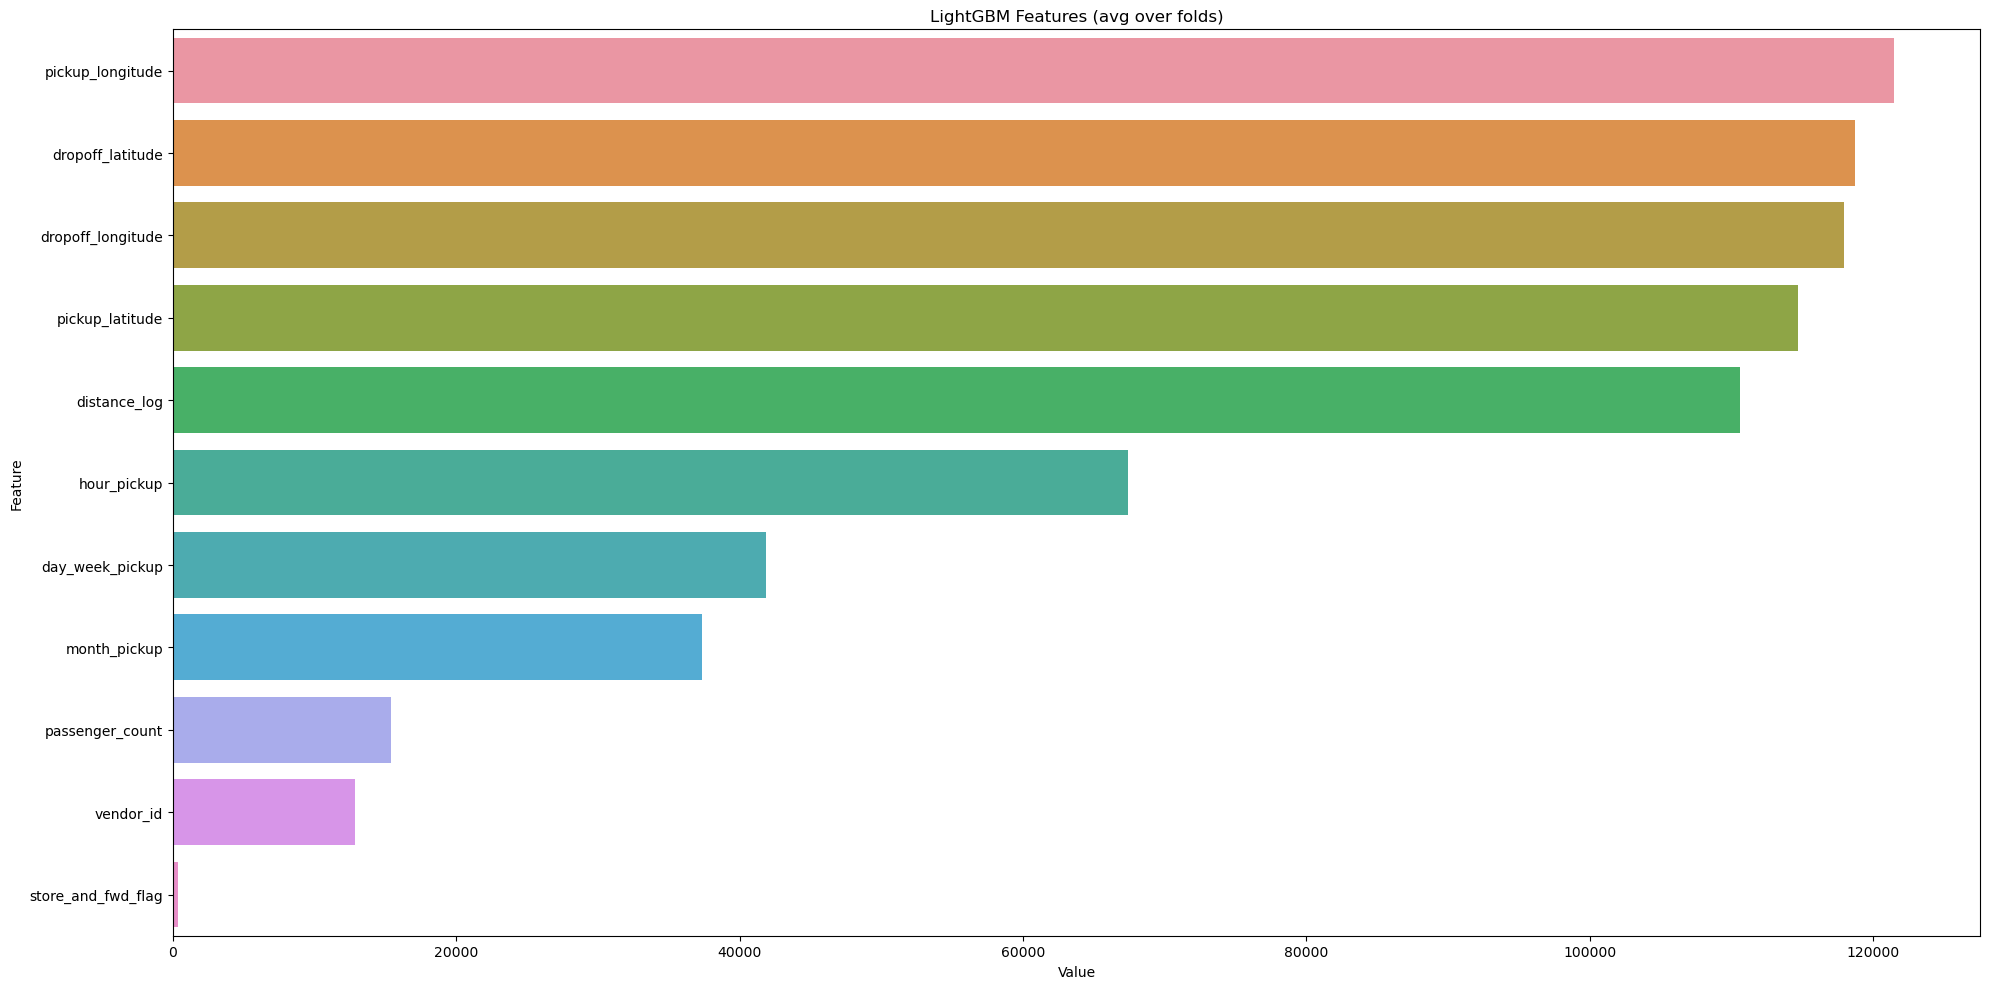

In [44]:
feature_imp = pd.DataFrame(sorted(zip(model_LGBM.steps[0][1].feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

Nota-se pela importância do recurso que as coordenadas de pickup e dropoff juntamente com a distância em log são as variáveis mais relevantes para a previsão do modelo.
A variável store_and_fwd_flag tem a menor relevância para a previsão do modelo, mostrando que pode ser removida sem perda da previsão do modelo.

# **Coclusão**

O resultado obtido com o algoritmo ficou próximo do resultado esperado e espera-se que quando aplicado aos dados de teste sejam obtidos resultados semelhantes.

A fim de melhorar o projeto em trabalhos futuros, as seguintes atividades podem ser realizadas:
- Remoção de Features que adicionam menos informações ao modelo, verificando o aumento de performance.
- Realizar uma melhor limpeza nos dados das coordenadas de embarque e desembarque, pois possuem maior poder preditivo.
- Criação de clusters para coordenadas de embarque e desembarque, visando criar variáveis alternativas para aumentar o poder preditivo.
- Aplicação de outros modelos de regressão para comparação de desempenho.

**Submission data**

In [45]:
def preprocessing(df):
    data = df.copy()
    # criando features auxiliares
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data = feature_creation(data)
    
    data['store_and_fwd_flag'] = label_encoder.fit_transform(data['store_and_fwd_flag']) 
    data['distance_log'] = np.log(data['distance'] +1)

    cols1 = ['vendor_id','store_and_fwd_flag']
    cols2 = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance_log','hour_pickup','day_week_pickup','month_pickup']
    

    data_scaler = pd.DataFrame(scaler.transform(data.loc[:,cols2]), columns = cols2)
    
    data_scaler = pd.concat([data_scaler, data.loc[:,cols1]], axis=1, ignore_index=False)
    
    return data_scaler

In [46]:
df_test = pd.read_csv('test.csv', header=0, sep=',', quotechar='"')
df_submission =pd.read_csv('sample_submission.csv', header=0, sep=',', quotechar='"')
X_test = preprocessing(df_test)

In [47]:
y_sub = model.predict(X_test)
y_sub_final = np.exp(y_sub)

In [48]:
df_submission['trip_duration'] = y_sub_final
df_submission[['id', 'trip_duration']].to_csv('./submission.csv', index = False)